In [1]:
#use extinction environment

import numpy as np
from math import log10, floor
from tqdm import tqdm
import shutil
from bisect import bisect_left
from random import sample
import lmfit

import matplotlib.pyplot as plt
from matplotlib import cm
plt.style.use('Software/stefan.mplstyle')

import pandas as pd
pd.set_option('display.max_columns', None)
# Suppress SettingWithCopyWarnings
pd.options.mode.chained_assignment = None  # default='warn'

from astropy.coordinates import SkyCoord
from astropy.coordinates import CartesianRepresentation, CartesianDifferential
import astropy.units as u

#for multiprocessing
from joblib import Parallel, delayed

#to include extinction
from __future__ import print_function
from dustmaps.edenhofer2023 import Edenhofer2023Query

import sys
import os
sys.path.append('Software')
import WD_models
from corv_nicole.utils import build_montreal_da
sys.path.append('Software/pyphot')
import pyphot


We could not find the pickled WD models
Please enter a new path to the Koester models.s
We could not find the pickled WD models. If you need to use these models, please re-import corv with the proper path.


# This notebook investigates whether dust clouds have a characteristic size that could create an ULDM-like effect in a Moran's I curve and then re-fits all photometry with no extinction corrections to characterize the impact of adding dust as a source of noise



# See how dust appears in a Moran's I curve

### Define functions and run simulation to characterize how the Moran's I curve appears for dust for smaller sample size (1000 WDs) on smaller grid (200x200 pc)

In [2]:
#import the VAC catalog measurements with quality cuts
wd_table=pd.read_csv('csv/wd_table.csv')


/var/folders/ny/bjybyvhj6s9_2ms5cmld1xbc0000gn/T/ipykernel_91893/646736903.py:2: DtypeWarning: Columns (18,25,77,88,100,109,114,126,127,292) have mixed types. Specify dtype option on import or set low_memory=False.
  wd_table=pd.read_csv('csv/wd_table.csv')


### Get the extinction at each test point using the Edenhofer 2023 dustmap

Green 2018
- https://joss.theoj.org/papers/10.21105/joss.00695
- Paper for the dustmaps python package

Dustmaps Package Website
- https://dustmaps.readthedocs.io/en/latest/examples.html
- The Bayestar2019 map is 3D, meaning it takes the full location of the object into account. This map is also probabalistic, meaning that it stores random samples of how dust reddening could increase along each sightline.
- Use mode='mean' or mode='median' to get the mean/median reddening
- Bayestar19 reports reddening in an arbitrary unit that can be converted to extinction in different bands using the coefficients given in Table 1 of Green, Schlafly, Finkbeiner et al. (2019).

Edenhofer et al. (2023)
- https://ui.adsabs.harvard.edu/abs/2023arXiv230801295E/abstract
- A three-dimensional map of Milky Way dust extinction, with a Gaussian process prior on the logarithm of the dust extinction density. The prior is implemented on a spherical grid. The map starts at 69 pc and extends out to 1.25 kpc in distance from the Sun. It has an angular resolution of 14’ and a maximum distance voxalization of 0.4 pc at 69 pc and a minimum distance voxalization of 7 pc at 1250 pc. The map is based on the stellar distance and extinction estimates of Zhang, Green & Rix (2023), and therefore reports extinctions in their units.
- We believe our dust reconstruction to be an underestimation of the true extinction toward dense dust clouds.
- For extremely low extinctions the assumption of A being Gaussian is poor due to the positivity prior in the ZGR23 catalog. We correct for this bias towards higher estimated extinction in regions with assumed extremely low true extinctions post-hoc by cutting away the innermost 69 pc as described in Section 5 and publish an auxiliary map of integrated extinction out to 69 pc from the sun to correct integrated LOS predictions for the removed extinction.
- Extinction is given in unitless E from Zhang 2023
- Zhang 2023 extinction curve https://zenodo.org/records/7811871
- From Edenhofer 2023 paper, they multiply E by 2.8 to get Av (see wavelength=540 nm on above extinction curve)
- all NaNs result from the object not being in the 69pc-1250pc validity range for this map. If the object is closer than 69 pc just set extinction to 0. If the object is further than 1250pc, set d=1250pc and get minimum extinction.


In [3]:
#download the data for the Edenhofer (2023) dustmap
"""
from dustmaps.config import config
config['data_dir'] = '~/Users/nicolecrumpler/anaconda3/envs/extinction/lib/python3.11/site-packages/dustmaps'

import dustmaps.edenhofer2023
dustmaps.edenhofer2023.fetch()
"""

"\nfrom dustmaps.config import config\nconfig['data_dir'] = '~/Users/nicolecrumpler/anaconda3/envs/extinction/lib/python3.11/site-packages/dustmaps'\n\nimport dustmaps.edenhofer2023\ndustmaps.edenhofer2023.fetch()\n"

### Make simulated test points on dusty background

In [3]:
def get_sample(table, sample_size, grid_size, plot=False):
    #this function places points on a 3D grid centered at the earth of size=grid_size
    #by drawing distances, l, and b from our VAC distrbutions
    #then convert distance, l, and b to cartesian coordinates
    
    #draw d,l,b coordinates
    all_measured_distances=table.query('r_med_geo<@grid_size')['r_med_geo']
    distance_sample = np.random.choice(all_measured_distances, size = sample_size, replace = True)
    all_measured_ls=table['l']
    l_sample = np.random.choice(all_measured_ls, size = sample_size, replace = True)
    all_measured_bs=table['b']
    b_sample = np.random.choice(all_measured_bs, size = sample_size, replace = True)
    
    #convert l, b, and distance (which are in galactic coordinates) to a cartesian representation
    coords_cartesian=SkyCoord(l=l_sample*u.deg, 
                              b=b_sample*u.deg, 
                              distance=distance_sample*u.pc,
                              frame='galactic')
    coords_cartesian.representation_type = 'cartesian'
    u_sample=coords_cartesian.u.value
    v_sample=coords_cartesian.v.value
    w_sample=coords_cartesian.w.value
    
    simulated_points=pd.DataFrame()
    #record these parameters
    simulated_points['distance']=distance_sample
    simulated_points['l']=l_sample
    simulated_points['b']=b_sample
    simulated_points['u']=u_sample
    simulated_points['v']=v_sample
    simulated_points['w']=w_sample
    
    #get the reddening at each point
    coords = SkyCoord(frame="galactic", l=l_sample*u.deg, b=b_sample*u.deg, distance = distance_sample*u.pc)
    # Query Edenhofer2023Query to get mean E(B-V) in arbitrary units
    ehq = Edenhofer2023Query(integrated=True) #integrated=True gives integrated extinction from coordinate
    ehq_mean = ehq.query(coords, mode='mean')
    # Convert E to Av
    simulated_points['av']=2.8*ehq_mean
    #below 69 pc, just set extinction to 0 since very near
    simulated_points['av']=simulated_points['av'].fillna(0)
    
    if plot==True:
        #plot the samples
        fig, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4,figsize=(20,5))
        
        ax1.hist(simulated_points['distance'], density=True, bins='auto', histtype='stepfilled')
        ax1.set_xlabel('Distance Sample\n(pc)')
        
        ax2.hist(simulated_points['l'], density=True, bins='auto', histtype='stepfilled')
        ax2.set_xlabel('l Sample\n(deg)')
        
        ax3.hist(simulated_points['b'], density=True, bins='auto', histtype='stepfilled')
        ax3.set_xlabel('b Sample\n(deg)')
        
        ax4.hist(simulated_points['av'], density=True, bins='auto', histtype='stepfilled')
        ax4.set_xlabel('Av Sample\n(mag)')
    
        plt.subplots_adjust(wspace = 0.3,hspace=0.4)

        plt.show()
        
    return(simulated_points)

Integrating extinction map (this might take a couple of minutes)...
Optimizing map for querying (this might take a couple of seconds)...


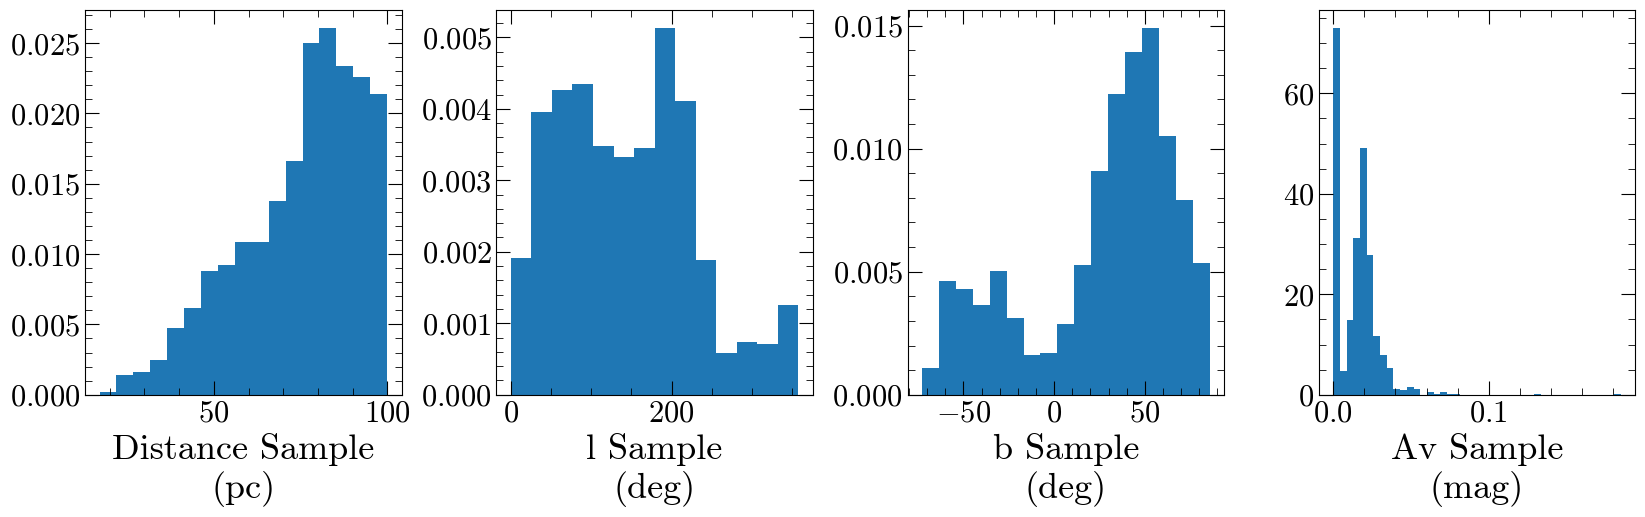

In [4]:
table=wd_table
sample_size=1000
grid_size=100

simulated_points=get_sample(table, sample_size, grid_size,plot=True)

### Calculate Moran's I Statistic at variety of distance cuts


In [6]:
def MoransI_contributions(simulated_points,sample_size,max_len=100000):
    #this function calculates the contribution to Moran's I from each pair
    
    #now only inputs are the measured values which might differ from the true values
    ucoords=simulated_points['u']
    vcoords=simulated_points['v']
    wcoords=simulated_points['w']
    reddening=simulated_points['av']
    
    median_av=np.median(reddening)
    
    #get difference between reddening and median reddening
    deviation=reddening-median_av
    
    #set maximum length of resulting i+j DataFrames to break up into pieces
    #otherwise can overwhelm memory when applying to >10,000 points

    #path to save outputs
    path='csv/nb05_sample_size_'+str(sample_size)+'/intermediate_files/'
    #make directory if does not exist
    try:
        os.makedirs(path)
    except:
        pass
    
    #make data frames both for when summing over each WD
    #and for when summing over each WD pair
    contributions_df_isum=pd.DataFrame()
    contributions_df_ijsum=pd.DataFrame()
    
    #compute N
    N=len(ucoords)
        
    #the expected deviation is 0 for dme=0, could also take mean of all deviations
    xbar=0
    
    #compute contributions, assuming weight=1
    #we will implement distance cuts later to calculate values as function of separation
    num_dfs_ijsum=1
    
    Ns=[]
    i_vals_ionly=[]
    denom_MI_conts=[]
    numerator_s3_conts=[]
    denom_s3_conts=[]
    
    i_vals=[]
    j_vals=[]
    separations=[]
    W_conts=[]
    numerator_MI_conts=[]
    s1_conts=[]
    s2_conts=[]
    
    for i in tqdm(range(N)):
        #record N and median absolute deviation
        Ns.append(N)

        #record WD index
        i_vals_ionly.append(i)

        #record Moran's I contributions
        denom_MI_conts.append((deviation[i]-xbar)**2)

        #record Z-score contributions
        numerator_s3_conts.append((deviation[i]-xbar)**4)
        denom_s3_conts.append((deviation[i]-xbar)**2)

    #save output
    contributions_df_isum['N']=Ns
    contributions_df_isum['i']=i_vals_ionly
    contributions_df_isum['denom_MI_cont']=denom_MI_conts
    contributions_df_isum['numerator_s3_cont']=numerator_s3_conts
    contributions_df_isum['denom_s3_cont']=denom_s3_conts
    contributions_df_isum.to_csv(path+'contributions_df_isum.csv',index=False)        
    
    current_len=0
    for i in tqdm(range(N)):
        for j in range(N):
            current_len+=1
            
            #record pair indices
            i_vals.append(i)
            j_vals.append(j)
            
            #record distance between WDs
            u1=ucoords[i]
            v1=vcoords[i]
            w1=wcoords[i]
            u2=ucoords[j]
            v2=vcoords[j]
            w2=wcoords[j]
            separations.append(np.sqrt((u1-u2)**2+(v1-v2)**2+(w1-w2)**2))
            
            #record W contribution
            W_conts.append(1)
            
            #record Moran's I contributions
            numerator_MI_conts.append((deviation[i]-xbar)*(deviation[j]-xbar))
            
            #record Z-score contributions
            s1_conts.append((1+1)**2)
            s2_conts.append((1+1)**2)
            
            #if have multiple of max_len rows then save current list in dataframe and .csv
            if current_len%max_len==0 and current_len!=0:
                #save results
                contributions_df_ijsum['i']=i_vals
                contributions_df_ijsum['j']=j_vals
                contributions_df_ijsum['separation']=separations
                contributions_df_ijsum['W_cont']=W_conts
                contributions_df_ijsum['numerator_MI_cont']=numerator_MI_conts
                contributions_df_ijsum['s1_cont']=s1_conts
                contributions_df_ijsum['s2_cont']=s2_conts
                contributions_df_ijsum.to_csv(path+'contributions_df_ijsum_'+str(num_dfs_ijsum)+'.csv',index=False)
                #record that are starting new DataFrame
                num_dfs_ijsum+=1
                #empty lists and DataFrame
                i_vals=[]
                j_vals=[]
                separations=[]
                W_conts=[]
                numerator_MI_conts=[]
                s1_conts=[]
                s2_conts=[]
                contributions_df_ijsum=pd.DataFrame()
    #whenever finish loop, also save output
    contributions_df_ijsum['i']=i_vals
    contributions_df_ijsum['j']=j_vals
    contributions_df_ijsum['separation']=separations
    contributions_df_ijsum['W_cont']=W_conts
    contributions_df_ijsum['numerator_MI_cont']=numerator_MI_conts
    contributions_df_ijsum['s1_cont']=s1_conts
    contributions_df_ijsum['s2_cont']=s2_conts
    contributions_df_ijsum.to_csv(path+'contributions_df_ijsum_'+str(num_dfs_ijsum)+'.csv',index=False)

    return(path,num_dfs_ijsum)


In [7]:
max_len=500000
path,num_dfs_ijsum=MoransI_contributions(simulated_points,sample_size,max_len)


100%|███████████████████████████████████████| 1000/1000 [00:11<00:00, 88.48it/s]


In [8]:
def MoransI_calculation(path,num_dfs_ijsum,distance_cuts):
    #this function calculates Moran's I at various distance cuts
    
    Ws=[]
    moransIs=[]
    expectations=[]
    variances=[]
    zscores=[]
    for d_cut in distance_cuts:
        #calculate each parameter by summing over the DataFrames
        
        #sums over individual WDs
        denom_MI=0
        numerator_s3=0
        denom_s3=0
        contributions_df_isum=pd.read_csv(path+'contributions_df_isum.csv')
        denom_MI+=contributions_df_isum['denom_MI_cont'].sum()
        numerator_s3=contributions_df_isum['numerator_s3_cont'].sum()
        denom_s3=contributions_df_isum['denom_s3_cont'].sum()
        
        #sums over WD pairs
        W=0
        s1=0
        s2=0
        numerator_MI=0
        for j in range(num_dfs_ijsum):
            contributions_df_ijsum=pd.read_csv(path+'contributions_df_ijsum_'+str(j+1)+'.csv')
            
            #keep only distances within the cut and drop any rows where i=j, this enforces the weight matrix
            apply_weights_df=contributions_df_ijsum.query('separation<=@d_cut and i!=j')
            
            W+=float(apply_weights_df['W_cont'].sum())
            numerator_MI+=apply_weights_df['numerator_MI_cont'].sum()
            s1+=apply_weights_df['s1_cont'].sum()
            s2+=apply_weights_df['s2_cont'].sum()
        
        
        N=float(contributions_df_isum.iloc[0]['N'])
        
        try:
            #Moran's I
            moransI=(N/W)*(numerator_MI/denom_MI)

            #expectation value
            expectation=-1/(N-1)

            #variance
            s1=(1/2)*s1
            s3=((1/N)*numerator_s3)/(((1/N)*denom_s3)**2)
            s4=(N**2-3*N+3)*s1-(N*s2)+(3*(W**2))
            s5=(N**2-N)*s1-(2*N*s2)+(6*(W**2))
            expect_Isqr=(N*s4-s3*s5)/((N-1)*(N-2)*(N-3)*(W**2))
            var=expect_Isqr-expectation**2

            #Z-score
            zscore=(moransI-expectation)/np.sqrt(var)
        except:
            moransI=np.nan
            expectation=np.nan
            var=np.nan
            zscore=np.nan
        
        #save results
        Ws.append(W)
        moransIs.append(moransI)
        expectations.append(expectation)
        variances.append(var)
        zscores.append(zscore)
        
    return(Ws,moransIs, expectations, variances,zscores)

In [9]:
d=100
MoransI_calculation(path,num_dfs_ijsum,[d])


([622608.0],
 [0.055538542246268266],
 [-0.001001001001001001],
 [5.178601055415799e-06],
 [24.84540428463778])

In [10]:
#calculate for range of distances from d=1 pc to order of magnitude of grid_size
max_exp=floor(log10(abs(grid_size)))
distances=np.logspace(0,max_exp,num=50)

Ws,moransIs, expectations, variances,zscores=MoransI_calculation(path,num_dfs_ijsum,distances)


22.0 1.93069772888325


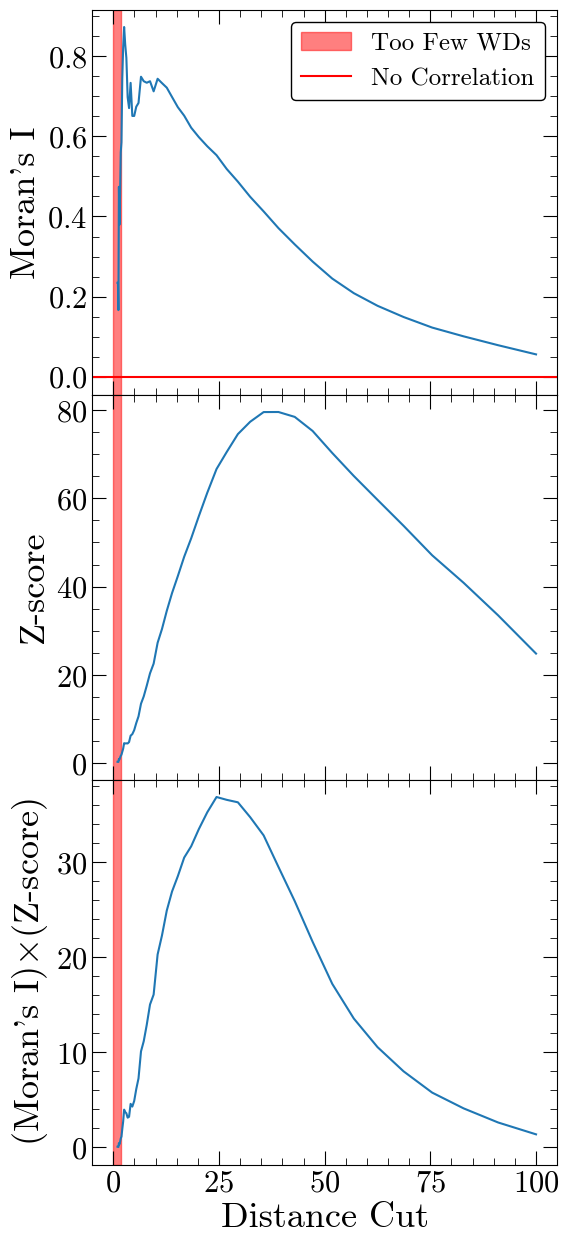

In [11]:
#plot

#cut to make sure have enough nonzero weights for valid results
nonzero_weight_cut=20
index = bisect_left(Ws, nonzero_weight_cut)
print(Ws[index],distances[index])

fig, ((ax1),(ax2),(ax3)) = plt.subplots(3,1,figsize=(6,15),sharex=True)
ax1.plot(distances,moransIs)
ax1.axvspan(0,distances[index],color='red',alpha=0.5,label='Too Few WDs')
ax1.axhline(expectations[0],color='red',label='No Correlation')
ax1.set_ylabel("Moran's I")
ax1.legend()

ax2.axvspan(0,distances[index],color='red',alpha=0.5,label='Too Few WDs')
ax2.plot(distances,zscores)
ax2.set_ylabel('Z-score')

mult=[]
for i in range(len(moransIs)):
    mult.append(moransIs[i]*zscores[i])

ax3.axvspan(0,distances[index],color='red',alpha=0.5,label='Too Few WDs')
ax3.plot(distances,mult)
ax3.set_xlabel('Distance Cut')
ax3.set_ylabel(r"(Moran's I)$\times$(Z-score)")

plt.subplots_adjust(wspace = 0,hspace=0)

### Put everything together and investigate the effects of dust 

In [12]:
def full_simulation(sample_size,grid_size,distances,iteration=None):
    
    #get sample
    simulated_points=get_sample(table, sample_size, grid_size)

    #get contributions of each WD pair to Moran's I
    path,num_dfs_ijsum=MoransI_contributions(simulated_points,sample_size)
    
    #calculate Moran's I for range of distances 
    Ws,moransIs, expectations, variances,zscores=MoransI_calculation(path,num_dfs_ijsum,distances)
  
    #write the data in a txt file
    np.savez('csv/nb05_sample_size_'+str(sample_size)+'/reddening'+str(iteration),Ws=Ws,distances=distances,moransIs=moransIs,expectations=expectations,variances=variances,zscores=zscores)  
    
    #delete the intermediate files
    shutil.rmtree(path)

In [13]:
def get_output(sample_size,iteration=None,nonzero_weight_cut=20,plot=True):
    #read back in measurements
    npzfile = np.load('csv/nb05_sample_size_'+str(sample_size)+'/reddening'+str(iteration)+'.npz')
    Ws = npzfile['Ws']
    final_distances = npzfile['distances']
    moransIs = npzfile['moransIs'] 
    expectations = npzfile['expectations']
    variances = npzfile['variances']
    zscores = npzfile['zscores']
    
    mult=[]
    for i in range(len(moransIs)):
        mult.append(moransIs[i]*zscores[i])
        
    #cut to make sure have enough nonzero weights for valid results
    index = bisect_left(Ws, nonzero_weight_cut)
    
    if plot:
        #plot
        fig, ((ax1),(ax2),(ax3)) = plt.subplots(3,1,figsize=(6,15),sharex=True)
        ax1.plot(final_distances,moransIs)
        ax1.axvspan(0,final_distances[index],color='red',alpha=0.5,label='Too Few WDs')
        ax1.axhline(expectations[0],color='red',label='No Correlation')
        ax1.set_ylabel("Moran's I")
        ax1.legend()

        ax2.plot(final_distances,zscores)
        ax2.axvspan(0,final_distances[index],color='red',alpha=0.5,label='Too Few WDs')
        ax2.set_ylabel('Z-score')

        ax3.plot(final_distances,mult)
        ax3.axvspan(0,final_distances[index],color='red',alpha=0.5,label='Too Few WDs')
        ax3.set_xlabel('Distance Cut')
        ax3.set_ylabel(r"(Moran's I)$\times$(Z-score)")

        plt.subplots_adjust(wspace = 0,hspace=0)
        plt.show()
    
    return(final_distances,Ws,moransIs,expectations,variances,zscores,mult,index)


In [14]:
#pick parameters
sample_size=1000
grid_size=100
max_exp=floor(log10(abs(grid_size)))
distances=np.logspace(0,max_exp,num=50)


Integrating extinction map (this might take a couple of minutes)...
Optimizing map for querying (this might take a couple of seconds)...
100%|███████████████████████████████████████| 1000/1000 [00:11<00:00, 89.92it/s]


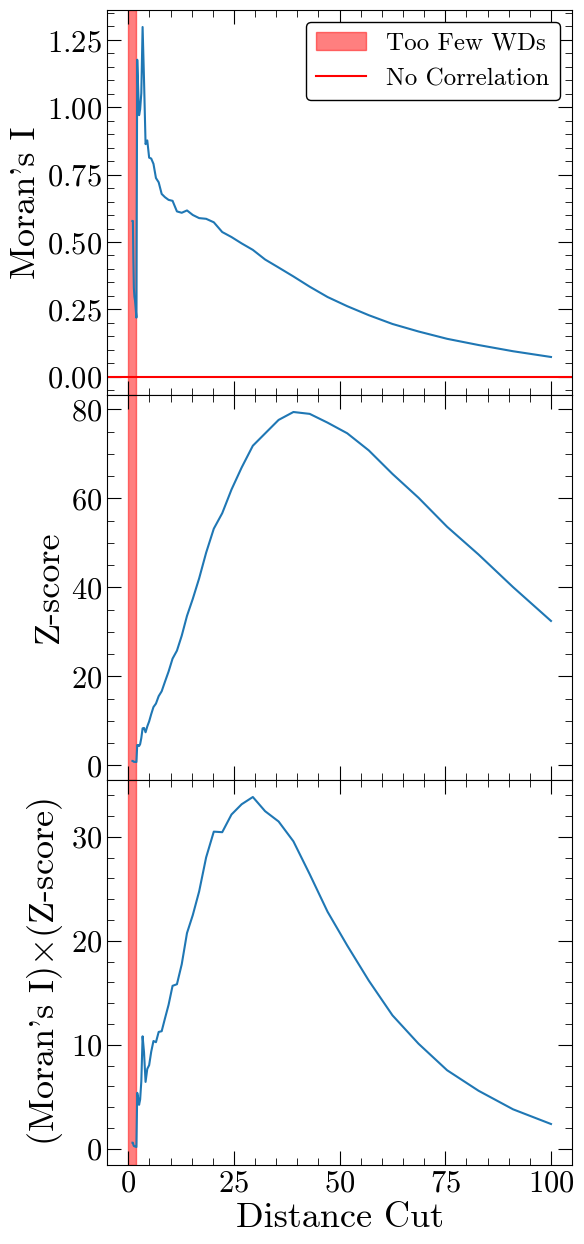

In [15]:
full_simulation(sample_size,grid_size,distances)
output=get_output(sample_size)


### Run 10 times for 10538 WDs within 1000pc


In [16]:
def parallelprocess(i):
    #pick parameters
    sample_size=10538
    grid_size=1000
    #distance cut array
    distances=np.array([1,3,6,9,12,15,18,21,24,27,30,35,40,45,50,55,60,70,80,90,100,125,150,175,200,225,250,275,300,325,350,375,400,
                                425,450,475,500,550,600,650,700,750,800,850,900,1000])
    full_simulation(sample_size,grid_size,distances,i)

In [53]:
#don't run in parallel or will overload memory
for i in range(10):
    print(i)
    parallelprocess(i)

0


Integrating extinction map (this might take a couple of minutes)...
Optimizing map for querying (this might take a couple of seconds)...
100%|█████████████████████████████████████| 10416/10416 [18:59<00:00,  9.14it/s]


1


Integrating extinction map (this might take a couple of minutes)...
Optimizing map for querying (this might take a couple of seconds)...
100%|█████████████████████████████████████| 10416/10416 [18:49<00:00,  9.22it/s]


2


Integrating extinction map (this might take a couple of minutes)...
Optimizing map for querying (this might take a couple of seconds)...
100%|█████████████████████████████████████| 10416/10416 [18:48<00:00,  9.23it/s]


3


Integrating extinction map (this might take a couple of minutes)...
Optimizing map for querying (this might take a couple of seconds)...
100%|█████████████████████████████████████| 10416/10416 [18:50<00:00,  9.21it/s]


4


Integrating extinction map (this might take a couple of minutes)...
Optimizing map for querying (this might take a couple of seconds)...
100%|█████████████████████████████████████| 10416/10416 [18:53<00:00,  9.19it/s]


5


Integrating extinction map (this might take a couple of minutes)...
Optimizing map for querying (this might take a couple of seconds)...
100%|█████████████████████████████████████| 10416/10416 [18:46<00:00,  9.24it/s]


6


Integrating extinction map (this might take a couple of minutes)...
Optimizing map for querying (this might take a couple of seconds)...
100%|█████████████████████████████████████| 10416/10416 [18:49<00:00,  9.23it/s]


7


Integrating extinction map (this might take a couple of minutes)...
Optimizing map for querying (this might take a couple of seconds)...
100%|█████████████████████████████████████| 10416/10416 [18:53<00:00,  9.19it/s]


8


Integrating extinction map (this might take a couple of minutes)...
Optimizing map for querying (this might take a couple of seconds)...
100%|█████████████████████████████████████| 10416/10416 [18:50<00:00,  9.21it/s]


9


Integrating extinction map (this might take a couple of minutes)...
Optimizing map for querying (this might take a couple of seconds)...
100%|█████████████████████████████████████| 10416/10416 [18:50<00:00,  9.22it/s]


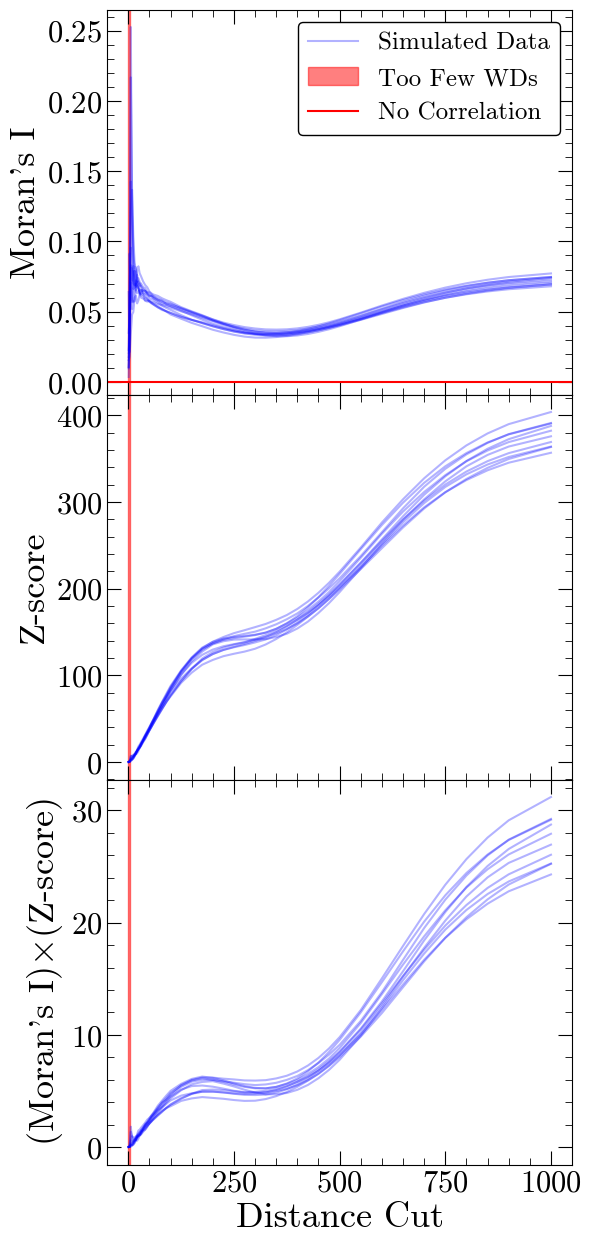

In [13]:
sample_size=10538

fig, ((ax1),(ax2),(ax3)) = plt.subplots(3,1,figsize=(6,15),sharex=True)
for i in range(10):
    final_distances,Ws,moransIs,expectations,variances,zscores,mult,index=get_output(sample_size,i,plot=False)
    if i==0:
        ax1.plot(final_distances,moransIs,color='blue',alpha=0.3,label='Simulated Data')
    else:
        ax1.plot(final_distances,moransIs,color='blue',alpha=0.3)
    ax2.plot(final_distances,zscores,color='blue',alpha=0.3)
    ax3.plot(final_distances,mult,color='blue',alpha=0.3)

ax1.axvspan(0,final_distances[index],color='red',alpha=0.5,label='Too Few WDs')
ax1.axhline(expectations[0],color='red',label='No Correlation')
ax1.set_ylabel("Moran's I")
ax1.legend()

ax2.axvspan(0,final_distances[index],color='red',alpha=0.5,label='Too Few WDs')
ax2.set_ylabel('Z-score')

ax3.axvspan(0,final_distances[index],color='red',alpha=0.5,label='Too Few WDs')
ax3.set_xlabel('Distance Cut')
ax3.set_ylabel(r"(Moran's I)$\times$(Z-score)")

plt.subplots_adjust(wspace = 0,hspace=0)
plt.show()

# On the scale of 1000 pc the signature of dust is distinct from the ULDM signature
- There are dust clouds of a variety of sizes, so the positive correlation appears at essentially all distance cuts in contrast to the ULDM field effect where the positive correlation dies off past the ULDM field correlation length.

# Re-fit all photometry without correcting for extinction. Use this to characterize how extinction corrections impact measured radii and temperatures

Repeat nb05 from the catalog paper, but do not correct for extinction

In [5]:
#already, the photometric parameters are the same for SDSS-V and eSDSS WDs, so we can just use the wd_table

#break the table into smaller sets

#make list of all unique object ids
obj_ids=wd_table['gaia_dr3_source_id'].unique()
np.savetxt('csv/unique_phot_short_sets/obj_ids.txt', obj_ids.astype(str), fmt="%s")

#break up object ids into sets of 500
#save each set of ids
set_size=400
num_id_sets=int(len(obj_ids)/set_size)+1
print(num_id_sets)
np.savetxt('csv/unique_phot_short_sets/num_id_sets.txt', np.array([num_id_sets]), fmt="%s")
id_dict={}
for i in tqdm(range(num_id_sets)):
    id_dict['set_'+str(i)]=obj_ids[set_size*i:set_size*i+set_size]
    #save list
    np.savetxt('csv/unique_phot_short_sets/obj_ids_'+str(i)+'.txt', id_dict['set_'+str(i)].astype(str), fmt="%s")
    
#make a .csv for each set of ids
for i in range(num_id_sets):
    obj_ids=id_dict['set_'+str(i)]
    #search dataframe for objects in obj_id list
    short_set=wd_table[wd_table['gaia_dr3_source_id'].isin(obj_ids)]
    #save
    short_set.to_csv('csv/unique_phot_short_sets/set_'+str(i)+'.csv',index=False)
    

26


100%|█████████████████████████████████████████| 26/26 [00:00<00:00, 1121.60it/s]


In [6]:
#read in all data tables
num_id_sets=np.genfromtxt('csv/unique_phot_short_sets/num_id_sets.txt',dtype=int)
dict_unique={}
for i in tqdm(range(num_id_sets)):
    dict_unique['set_'+str(i)]=pd.read_csv('csv/unique_phot_short_sets/set_'+str(i)+'.csv')

100%|███████████████████████████████████████████| 26/26 [00:00<00:00, 95.18it/s]


### Define functions to fit the Photometry with Warwick Templates and Pyphot

Fit with both SDSS and Gaia photometry if available

Fit for lo, med, and high distance photometry

In [7]:
#physical constants in CGS units
c = 2.998e10 #cm/s
k = 1.38e-16 #erg/K
h = 6.626e-27 #erg s

#Balmer series line centroids, for vacuum wavelengths
halpha = 6564.61 #ang
hbeta = 4862.68 #ang
hgamma = 4341.68 #ang
hdelta = 4102.89 #ang

#physical constants in SI units
speed_light = 299792458 #m/s
radius_sun = 6.957e8 #m
mass_sun = 1.9884e30 #kg
newton_G = 6.674e-11 #N m^2/kg^2
pc_to_m = 3.086775e16

#get the Warwick DA model
modpath_m='models/montreal_da'
base_wavl, montreal_model, montreal_model_low_logg, table = build_montreal_da(modpath_m,flux_unit = 'flam')


In [8]:
def mag_to_flux_spec_Vega(mag, filt, e_mag = None):
    #convert from magntiudes on the Vega system to flux for a particular filter
    #Gaia magnitudes are on the Vega system
    if e_mag is not None:
        #compute the flux error given the error on the magnitude
        #assume the error on the zero point is negligible
        return (10**(-0.4*(mag + filt.Vega_zero_mag)), np.abs((np.log(10)*(-0.4)*10**(-0.4 * (mag + filt.Vega_zero_mag)) * e_mag)))
    else:
        return 10**(-0.4*(mag + filt.Vega_zero_mag))
    
def mag_to_flux_spec_AB(mag, filt, e_mag = None):
    #convert from magntiudes on the AB system to flux for a particular filter
    #SDSS magnitudes are on the AB system
    if e_mag is not None:
        #compute the flux error given the error on the magnitude
        #assume the error on the zero point is negligible
        return (10**(-0.4*(mag + filt.AB_zero_mag)), np.abs((np.log(10)*(-0.4)*10**(-0.4 * (mag + filt.AB_zero_mag)) * e_mag)))
    else:
        return 10**(-0.4*(mag + filt.AB_zero_mag))
    
def template(teff, logg, radius, distance):
    #get montreal model flux spectrum for a WD with a given radius, located a given distance away
    
    fl= 4*np.pi*montreal_model((teff,logg))#flux in physical units
    
    #convert to SI units
    radius = radius * radius_sun # Rsun to meter
    distance = distance * pc_to_m # Parsec to meter
    
    fl = (radius / distance)**2 * fl
    return fl
    

def get_model_flux_sdss(params):
    #get model photometric flux for a WD with a given radius, located a given distance away
    teff, logg, radius, distance = params['teff'], params['logg'], params['radius'], params['distance']
    
    fl = template(teff, logg, radius, distance) 
            
    flux = np.array([sdss_filters[i].get_flux(base_wavl * pyphot.unit['angstrom'], fl * pyphot.unit['erg/s/cm**2/angstrom'], axis = 1).to('erg/s/cm**2/angstrom').value for i in range(len(sdss_filters))])
    return flux

def get_model_flux_gaia(params):
    #get model photometric flux for a WD with a given radius, located a given distance away
    teff, logg, radius, distance = params['teff'], params['logg'], params['radius'], params['distance']
    
    fl = template(teff, logg, radius, distance) 
            
    flux = np.array([gaia_filters[i].get_flux(base_wavl * pyphot.unit['angstrom'], fl * pyphot.unit['erg/s/cm**2/angstrom'], axis = 1).to('erg/s/cm**2/angstrom').value for i in range(len(gaia_filters))])
    return flux
    

def residual_sdss(params, obs_flux = None, e_obs_flux = None):
    #calculate the chi2 between the model and the fit
    model_flux = get_model_flux_sdss(params)
    
    chisquare = ((model_flux - obs_flux) / e_obs_flux)**2

    return chisquare

def residual_gaia(params, obs_flux = None, e_obs_flux = None):
    #calculate the chi2 between the model and the fit
    model_flux = get_model_flux_gaia(params)

    chisquare = ((model_flux - obs_flux) / e_obs_flux)**2

    return chisquare

def get_parameters_sdss(obs_flux, e_obs_flux, vary_logg=False, p0 = [10000, 8, 0.003, 100]):          
    #use lmfit.minimize to fit the model to the data
    params = lmfit.Parameters()
    params.add('teff', value = p0[0], min = 1501, max = 129999, vary = True)
    params.add('logg', value = p0[1], min=7, max=9, vary=vary_logg)
    params.add('radius', value = p0[2], min = 0.000001, max = 0.05, vary = True)
    params.add('distance', value = p0[3], min = 1, max = 20000, vary = False)
            
    result = lmfit.minimize(residual_sdss, params, kws = dict(obs_flux = obs_flux, e_obs_flux = e_obs_flux), method = 'leastsq')
        
    return result

def get_parameters_gaia(obs_flux, e_obs_flux, vary_logg=False, p0 = [10000, 8, 0.003, 100]):          
    #use lmfit.minimize to fit the model to the data
    params = lmfit.Parameters()
    params.add('teff', value = p0[0], min = 1501, max = 129999, vary = True)
    params.add('logg', value = p0[1], min=7, max=9, vary=vary_logg)
    params.add('radius', value = p0[2], min = 0.000001, max = 0.05, vary = True)
    params.add('distance', value = p0[3], min = 1, max = 20000, vary = False)
            
    result = lmfit.minimize(residual_gaia, params, kws = dict(obs_flux = obs_flux, e_obs_flux = e_obs_flux), method = 'leastsq')
        
    return result

In [9]:
# Use pyphot to get the SDSS and Gaia photometric band wavelengths we want to fit
lib = pyphot.get_library()
sdss_filters = [lib['SDSS_u'],lib['SDSS_r'],lib['SDSS_z']]
sdss_phot_wavl = np.array([x.lpivot.to('angstrom').value for x in sdss_filters])
gaia_filters = [lib['Gaia_BP'], lib['Gaia_RP']]
gaia_phot_wavl = np.array([x.lpivot.to('angstrom').value for x in gaia_filters])

In [10]:
def fit_phot(wd_table,distance_set,plot=False,savefig=False):
    
    #For SDSS fit allowing logg to vary, if the fit fails or hits the edge of the grid
    #fit logg=7,8,9 and add difference in quadrature
    
    #for Gaia, fit logg=7,8,9 and add difference in quadrature
    #allowing logg to vary results in hitting the edge of the grid
    
    radius_array_sdss=[]
    e_radius_array_sdss=[]
    teff_array_sdss=[]
    e_teff_array_sdss=[]
    logg_array_sdss=[]
    e_logg_array_sdss=[]
    redchi_array_sdss=[]
    
    radius_array_gaia=[]
    e_radius_array_gaia=[]
    teff_array_gaia=[]
    e_teff_array_gaia=[]
    logg_array_gaia=[]
    e_logg_array_gaia=[]
    redchi_array_gaia=[]
    
    #add a flag to indicate whether SDSS or Gaia photometry was used (or if there's no good available photometry)
    #0=no phot, 1=SDSS, 2=Gaia
    photometry_source_flag=np.full(len(wd_table), 0)
    #add a flag to indicate whether logg was fixed
    #0=fit failed/no_phot for that survey, 1=logg free to vary, 2=logg fixed
    sdss_logg_flag=[]
    gaia_logg_flag=[]
    
    for i in tqdm(range(len(wd_table))):
        #fit objects with clean SDSS photometry
        if wd_table['no_sdss_phot'][i]==False and wd_table['clean'][i]==1:
            #convert SDSS magnitudes to flux in erg/s/cm^2/AA
            #THESE MAGNITUDES ARE NOT EXTINCTION-CORRECTED
            obs_flux_u, e_obs_flux_u = mag_to_flux_spec_AB(wd_table['mag_ab_u'][i],sdss_filters[0],wd_table['magerr_ab_u'][i])
            obs_flux_r, e_obs_flux_r = mag_to_flux_spec_AB(wd_table['mag_ab_r'][i],sdss_filters[1],wd_table['magerr_ab_r'][i])
            obs_flux_z, e_obs_flux_z = mag_to_flux_spec_AB(wd_table['mag_ab_z'][i],sdss_filters[2],wd_table['magerr_ab_z'][i])
            obs_flux=np.array([obs_flux_u,obs_flux_r,obs_flux_z])
            e_obs_flux=np.array([e_obs_flux_u,e_obs_flux_r,e_obs_flux_z])
            
            #first fit for varying logg
            result = get_parameters_sdss(obs_flux,e_obs_flux,vary_logg=True,p0 = [10000, 8, 0.003, wd_table['r_'+distance_set+'_geo'][i]])
            
            #check if the fit failed
            try:
                check_nan=[result.params['radius'].stderr,result.params['radius'].value,result.params['teff'].stderr,
                       result.params['teff'].value,result.params['logg'].stderr,result.params['logg'].value]
                fit_fail=np.isnan(check_nan).any()
                #also check if the logg fit hits the edge of the grid
                if np.abs(result.params['logg'].value-7)<0.001 or np.abs(result.params['logg'].value-9)<0.001:
                    fit_fail=True
                    
            except:
                fit_fail=True
                
            if fit_fail==True:
                #if that fails, fit for logg=7,8,9
                logg7 = get_parameters_sdss(obs_flux,e_obs_flux,p0 = [10000, 7, 0.003, wd_table['r_'+distance_set+'_geo'][i]])
                logg8 = get_parameters_sdss(obs_flux,e_obs_flux,p0 = [10000, 8, 0.003, wd_table['r_'+distance_set+'_geo'][i]])
                logg9 = get_parameters_sdss(obs_flux,e_obs_flux,p0 = [10000, 9, 0.003, wd_table['r_'+distance_set+'_geo'][i]])
            
            #save the fit results
            if fit_fail==False:
                #radius in solar units
                radius=result.params['radius'].value
                radius_array_sdss.append(radius)
                #error on the radius is stderr in measured radius
                err=result.params['radius'].stderr
                e_radius_array_sdss.append(err)
                #photometric temperature in K
                teff=result.params['teff'].value
                teff_array_sdss.append(teff)
                #error on photometric temperature in K
                e_teff=result.params['teff'].stderr
                e_teff_array_sdss.append(e_teff)
                #photometric logg in dex
                logg=result.params['logg'].value
                logg_array_sdss.append(logg)
                #error on photometric logg in dex
                e_logg=result.params['logg'].stderr
                e_logg_array_sdss.append(e_logg)
                #reduced chi2
                redchi_val=result.redchi
                redchi_array_sdss.append(redchi_val)
            
            fit_fail_fixed=False
            
            if fit_fail==True:
                #radius in solar units
                try:
                    radius=logg8.params['radius'].value
                    radius_array_sdss.append(radius)
                except:
                    radius_array_sdss.append(np.nan)
                    fit_fail_fixed=True
                #error on the radius is stderr in measured radius and the absolute value of the difference in the logg=7,9 radius results added in quadrature
                try:
                    err=np.sqrt(logg8.params['radius'].stderr**2 + np.abs(logg7.params['radius'].value - logg9.params['radius'].value)**2 )
                    e_radius_array_sdss.append(err)
                except:
                    e_radius_array_sdss.append(np.nan)
                    fit_fail_fixed=True
                #photometric temperature in K
                try:
                    teff=logg8.params['teff'].value
                    teff_array_sdss.append(teff)
                except:
                    teff_array_sdss.append(np.nan)
                    fit_fail_fixed=True
                #error on photometric temperature in K
                try:
                    e_teff=np.sqrt(logg8.params['teff'].stderr**2 + np.abs(logg7.params['teff'].value - logg9.params['teff'].value)**2 )
                    e_teff_array_sdss.append(e_teff)
                except:
                    e_teff_array_sdss.append(np.nan)
                    fit_fail_fixed=True
                #photometric logg in dex
                logg=8
                logg_array_sdss.append(logg)
                #error on photometric logg in dex
                e_logg=np.nan
                e_logg_array_sdss.append(e_logg)
                #reduced chi2
                try:
                    redchi_val=logg8.redchi
                    redchi_array_sdss.append(redchi_val)
                except:
                    redchi_array_sdss.append(np.nan)
                    fit_fail_fixed=True
                    
            #add the flag information
            if fit_fail==False:
                flag=1
                plot_result=result
            elif fit_fail_fixed==False:
                flag=2
                plot_result=logg8
            else:
                flag=0
                plot_result=logg8
            sdss_logg_flag.append(flag)
            
        
            if plot==True:
                #get the SDSS filter information
                sdss_u_info=pd.read_csv('Software/pyphot/libs/ascii_sources/sdss_u.csv',skiprows=8)
                sdss_r_info=pd.read_csv('Software/pyphot/libs/ascii_sources/sdss_r.csv',skiprows=8)
                sdss_z_info=pd.read_csv('Software/pyphot/libs/ascii_sources/sdss_z.csv',skiprows=8)
                # plot the model spectrum, model photometric flux, observed photometric flux, and SDSS urz filter response curves
                # with the fit results
                
                fig_sdss, ax1 =plt.subplots(1,1,figsize=(9,9))
                ax1.errorbar([sdss_filters[j].lpivot.to('angstrom').value for j in range(len(sdss_filters))], obs_flux, yerr = e_obs_flux, linestyle = 'none', marker = 'None', color = 'k', capsize = 5, label = 'Observed SED', zorder = 10)
                ax1.plot([sdss_filters[j].lpivot.to('angstrom').value for j in range(len(sdss_filters))], get_model_flux_sdss(plot_result.params), 'co', markersize = 10, label = 'Model SED')
                
                ax1.fill_between(x= sdss_u_info['WAVELENGTH'], y1= sdss_u_info['THROUGHPUT']*obs_flux[0],color= 'k',alpha= 0.2,label='Filter Response Curve')
                ax1.fill_between(x= sdss_r_info['WAVELENGTH'], y1= sdss_r_info['THROUGHPUT']*obs_flux[0],color= 'k',alpha= 0.2)
                ax1.fill_between(x= sdss_z_info['WAVELENGTH'], y1= sdss_z_info['THROUGHPUT']*obs_flux[0],color= 'k',alpha= 0.2)
                
                model_fl = template(plot_result.params['teff'].value, plot_result.params['logg'].value, plot_result.params['radius'].value, plot_result.params['distance'].value)
                mask = (3600 < base_wavl)*(base_wavl<9000)
                ax1.plot(base_wavl[mask], model_fl[mask], c = 'k', label = 'Model Spectrum')
                
                ax1.text(0.57, 0.70,  "$T_{eff}$" + " = {:2.6} $K$".format(plot_result.params['teff'].value), transform = plt.gca().transAxes, fontsize = 18)
                ax1.text(0.57, 0.65, "$\log g$" + " = {:2.5f}".format(plot_result.params['logg'].value), transform = plt.gca().transAxes, fontsize = 18)
                ax1.text(0.57, 0.60, r'$Radius = ${:2.5f} $R_\odot$'.format(plot_result.params['radius'].value), transform = plt.gca().transAxes, fontsize = 18)
                ax1.text(0.57, 0.55, '$Distance = ${:2.1f} $pc$'.format(plot_result.params['distance'].value), transform = plt.gca().transAxes, fontsize=18)
                ax1.text(0.57, 0.50, r'$\chi_r^2 = ${:2.2f}'.format(plot_result.redchi), transform = plt.gca().transAxes, fontsize = 18)
                
                ax1.set_xlim((3450, 9000))
                ax1.set_xlabel(r'Wavelength $(\AA)$')
                ax1.set_ylabel('Flux $(erg/s/cm^2/\AA)$')
                ax1.set_title('SDSS $u$+$r$+$z$ Photometric Fit')
                ax1.legend()
                plt.show()
        else:
            #no clean SDSS photometry available
            radius_array_sdss.append(np.nan)
            e_radius_array_sdss.append(np.nan)
            teff_array_sdss.append(np.nan)
            e_teff_array_sdss.append(np.nan)
            logg_array_sdss.append(np.nan)
            e_logg_array_sdss.append(np.nan)
            redchi_array_sdss.append(np.nan)
            sdss_logg_flag.append(0)
            fig_sdss=None
            
        #fit objects with clean Gaia photometry
        if wd_table['no_gaia_phot'][i]==False and wd_table['phot_bp_rp_excess_factor'][i]<2:
            
            #convert Gaia magnitude to flux in erg/s/cm^2/AA
            #THESE MAGNITUDES ARE NOT EXTINCTION-CORRECTED
            obs_flux = np.array([mag_to_flux_spec_Vega(wd_table['phot_bp_mean_mag'][i], gaia_filters[0]),
                                 mag_to_flux_spec_Vega(wd_table['phot_rp_mean_mag'][i], gaia_filters[1])])
            #convert Gaia flux errors (electron/s) to erg/s/cm^2/AA
            e_obs_flux = np.array([wd_table['phot_bp_mean_flux_error'][i] * 3.009167e-21 *100, 
                               wd_table['phot_rp_mean_flux_error'][i] * 1.638483e-21 *100])
            #fit for logg=7,8,9
            logg7 = get_parameters_gaia(obs_flux,e_obs_flux,p0 = [10000, 7, 0.003, wd_table['r_'+distance_set+'_geo'][i]])
            logg8 = get_parameters_gaia(obs_flux,e_obs_flux,p0 = [10000, 8, 0.003, wd_table['r_'+distance_set+'_geo'][i]])
            logg9 = get_parameters_gaia(obs_flux,e_obs_flux,p0 = [10000, 9, 0.003, wd_table['r_'+distance_set+'_geo'][i]])
                
            #save the fit results
            fit_fail_fixed=False
            #radius in solar units
            try:
                radius=logg8.params['radius'].value
                radius_array_gaia.append(radius)
            except:
                radius_array_gaia.append(np.nan)
                fit_fail_fixed=True
            #error on the radius is stderr in measured radius and the absolute value of the difference in the logg=7,9 radius results added in quadrature
            try:
                err=np.sqrt(logg8.params['radius'].stderr**2 + np.abs(logg7.params['radius'].value - logg9.params['radius'].value)**2 )
                e_radius_array_gaia.append(err)
            except:
                e_radius_array_gaia.append(np.nan)
                fit_fail_fixed=True
            #photometric temperature in K
            try:
                teff=logg8.params['teff'].value
                teff_array_gaia.append(teff)
            except:
                teff_array_gaia.append(np.nan)
                fit_fail_fixed=True
            #error on photometric temperature in K
            try:
                e_teff=np.sqrt(logg8.params['teff'].stderr**2 + np.abs(logg7.params['teff'].value - logg9.params['teff'].value)**2 )
                e_teff_array_gaia.append(e_teff)
            except:
                e_teff_array_gaia.append(np.nan)
                fit_fail_fixed=True
            #photometric logg in dex
            logg=8
            logg_array_gaia.append(logg)
            #error on photometric logg in dex
            e_logg=np.nan
            e_logg_array_gaia.append(e_logg)
            #reduced chi2
            try:
                redchi_val=logg8.redchi
                redchi_array_gaia.append(redchi_val)
            except:
                redchi_array_gaia.append(np.nan)
                fit_fail_fixed=True
                    
            #add the flag information
            if fit_fail_fixed==False:
                flag=2
                plot_result=logg8
            else:
                flag=0
                plot_result=logg8
            gaia_logg_flag.append(flag)
        
            if plot==True:
                #get the Gaia filter information
                gaia_bp_info=pd.read_csv('Software/pyphot/libs/ascii_sources/gaiadr2_bp.csv',skiprows=8)
                gaia_rp_info=pd.read_csv('Software/pyphot/libs/ascii_sources/gaiadr2_rp.csv',skiprows=8)
                #gaia_g_info=pd.read_csv('../Software/pyphot/pyphot/libs/ascii_sources/gaiadr2_g.csv',skiprows=8)
                # plot the model spectrum, model photometric flux, and observed photometric flux
                # with the fit results
                
                fig_gaia, ax1 =plt.subplots(1,1,figsize=(9,9))
                ax1.errorbar([gaia_filters[j].lpivot.to('angstrom').value for j in range(len(gaia_filters))], obs_flux, yerr = e_obs_flux, linestyle = 'none', marker = 'None', color = 'k', capsize = 5, label = 'Observed SED', zorder = 10)   
                ax1.plot([gaia_filters[j].lpivot.to('angstrom').value for j in range(len(gaia_filters))], get_model_flux_gaia(plot_result.params), 'co', markersize = 10, label = 'Model SED')  
                ax1.fill_between(x= gaia_bp_info['WAVELENGTH']*10, y1= gaia_bp_info['THROUGHPUT']*obs_flux[0],color= 'k',alpha= 0.2,label='Filter Response Curve')
                ax1.fill_between(x= gaia_rp_info['WAVELENGTH']*10, y1= gaia_rp_info['THROUGHPUT']*obs_flux[0],color= 'k',alpha= 0.2)
                #ax1.fill_between(x= gaia_g_info['WAVELENGTH']*10, y1= gaia_g_info['THROUGHPUT']*obs_flux[0],color= 'k',alpha= 0.2)
                
                model_fl = template(plot_result.params['teff'].value, plot_result.params['logg'].value, plot_result.params['radius'].value, plot_result.params['distance'].value)
                mask = (3600 < base_wavl)*(base_wavl<9000)
                ax1.plot(base_wavl[mask], model_fl[mask], c = 'k', label = 'Model Spectrum')
                
                ax1.text(0.57, 0.70, "$T_{eff}$" + " = {:2.6} $K$".format(plot_result.params['teff'].value), transform = plt.gca().transAxes, fontsize = 18)
                ax1.text(0.57, 0.65, "$\log g$" + " = {:2.5f}".format(plot_result.params['logg'].value), transform = plt.gca().transAxes, fontsize = 18)
                ax1.text(0.57, 0.60, r'$Radius = ${:2.5f} $R_\odot$'.format(plot_result.params['radius'].value), transform = plt.gca().transAxes, fontsize = 18)
                ax1.text(0.57, 0.55, '$Distance = ${:2.1f} $pc$'.format(plot_result.params['distance'].value), transform = plt.gca().transAxes, fontsize=18)
                ax1.text(0.57, 0.50, r'$\chi_r^2 = ${:2.2f}'.format(plot_result.redchi), transform = plt.gca().transAxes, fontsize = 18)
                
                ax1.set_xlim((3450, 9000))
                ax1.set_xlabel(r'Wavelength $(\AA)$')
                ax1.set_ylabel('Flux $(erg/s/cm^2/\AA)$')
                ax1.set_title('Gaia $G_{BP}$+$G_{RP}$ Photometric Fit')
                ax1.legend()
                plt.show()
        else:
            #no clean gaia photometry available
            radius_array_gaia.append(np.nan)
            e_radius_array_gaia.append(np.nan)
            teff_array_gaia.append(np.nan)
            e_teff_array_gaia.append(np.nan)
            logg_array_gaia.append(np.nan)
            e_logg_array_gaia.append(np.nan)
            redchi_array_gaia.append(np.nan)
            gaia_logg_flag.append(0)
            fig_gaia=None
            
        #add the photometry source flag
        if wd_table['no_sdss_phot'][i]==False and wd_table['clean'][i]==1:
            photometry_source_flag[i]=1
        elif wd_table['no_gaia_phot'][i]==False and wd_table['phot_bp_rp_excess_factor'][i]<2:
            photometry_source_flag[i]=2
        else:
            pass
    
    if savefig==True:
        return(fig_sdss,fig_gaia)
    else:
        return(photometry_source_flag,radius_array_sdss,e_radius_array_sdss,teff_array_sdss,e_teff_array_sdss,
               logg_array_sdss,e_logg_array_sdss,redchi_array_sdss,
               radius_array_gaia,e_radius_array_gaia,teff_array_gaia,e_teff_array_gaia,
               redchi_array_gaia,sdss_logg_flag,gaia_logg_flag)
            

### show some fits

  0%|                                                    | 0/10 [00:00<?, ?it/s]

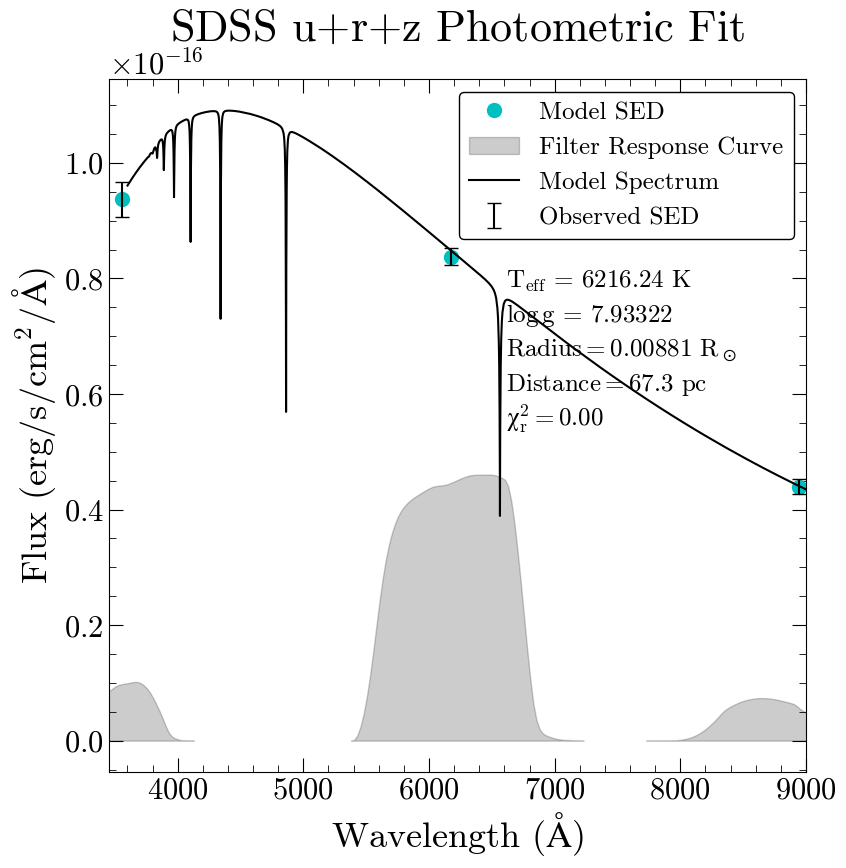

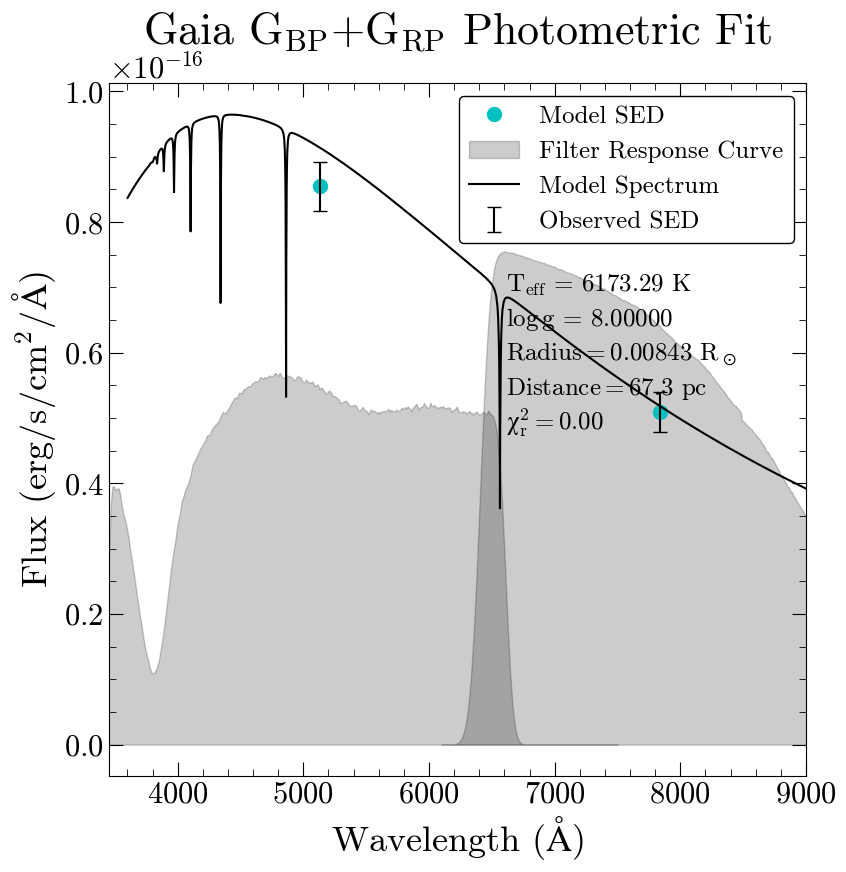

 10%|████▍                                       | 1/10 [00:01<00:11,  1.33s/it]

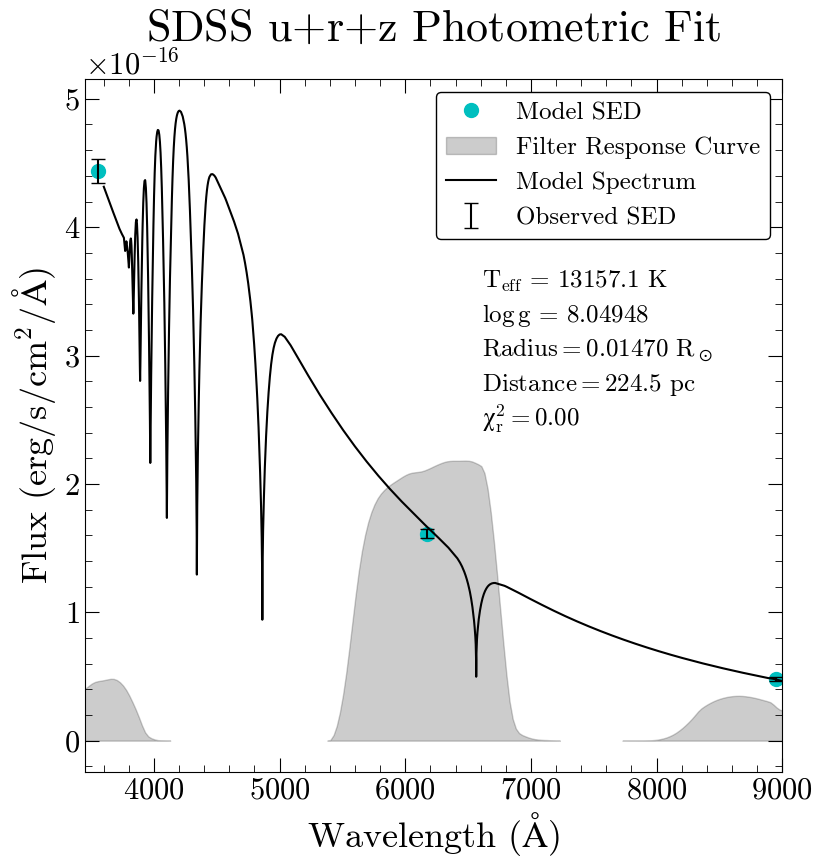

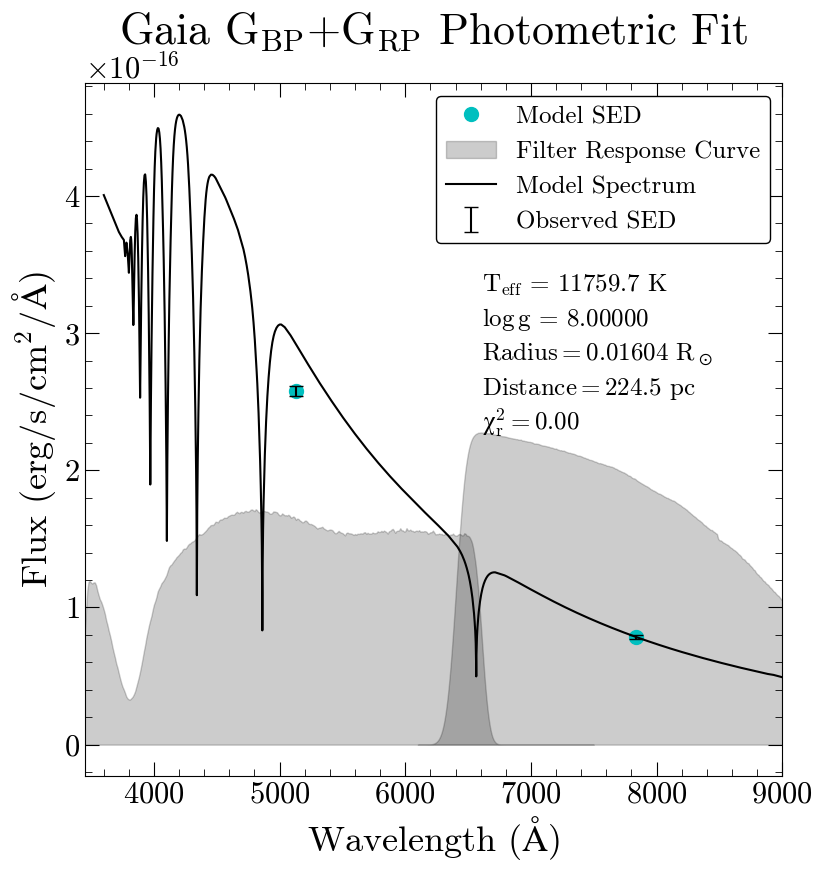

 20%|████████▊                                   | 2/10 [00:02<00:09,  1.15s/it]

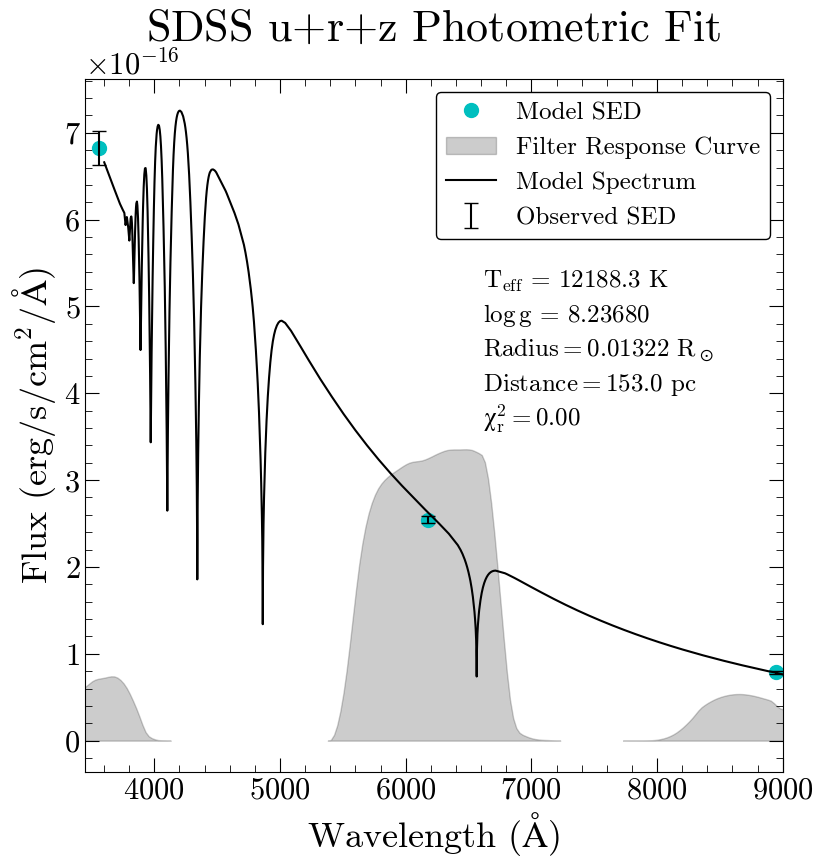

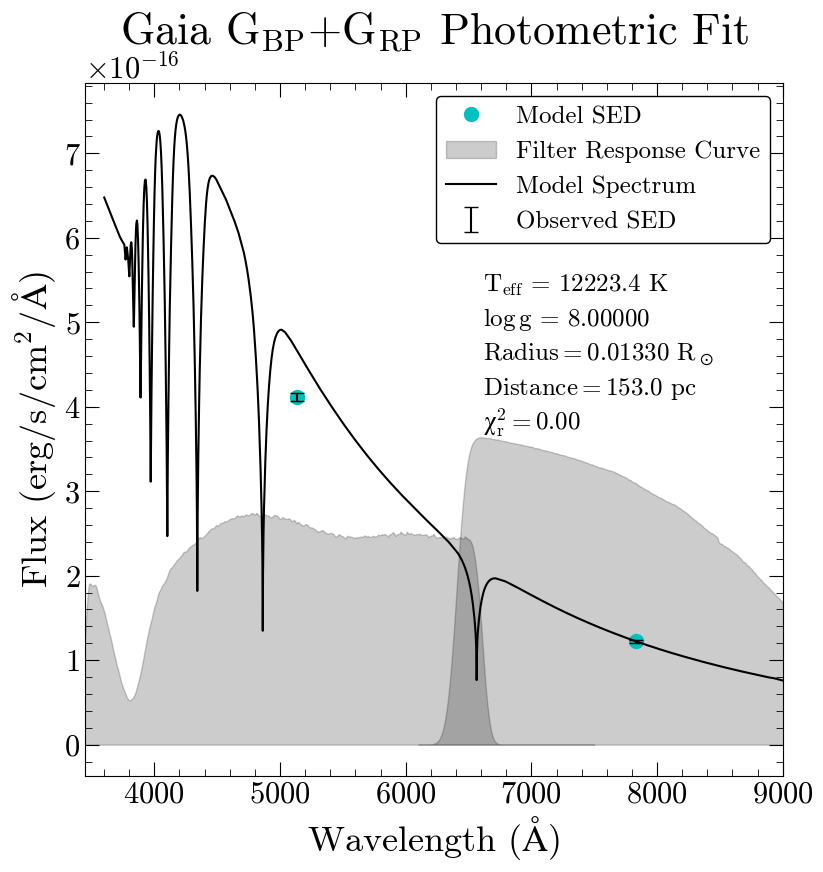

 30%|█████████████▏                              | 3/10 [00:03<00:07,  1.06s/it]

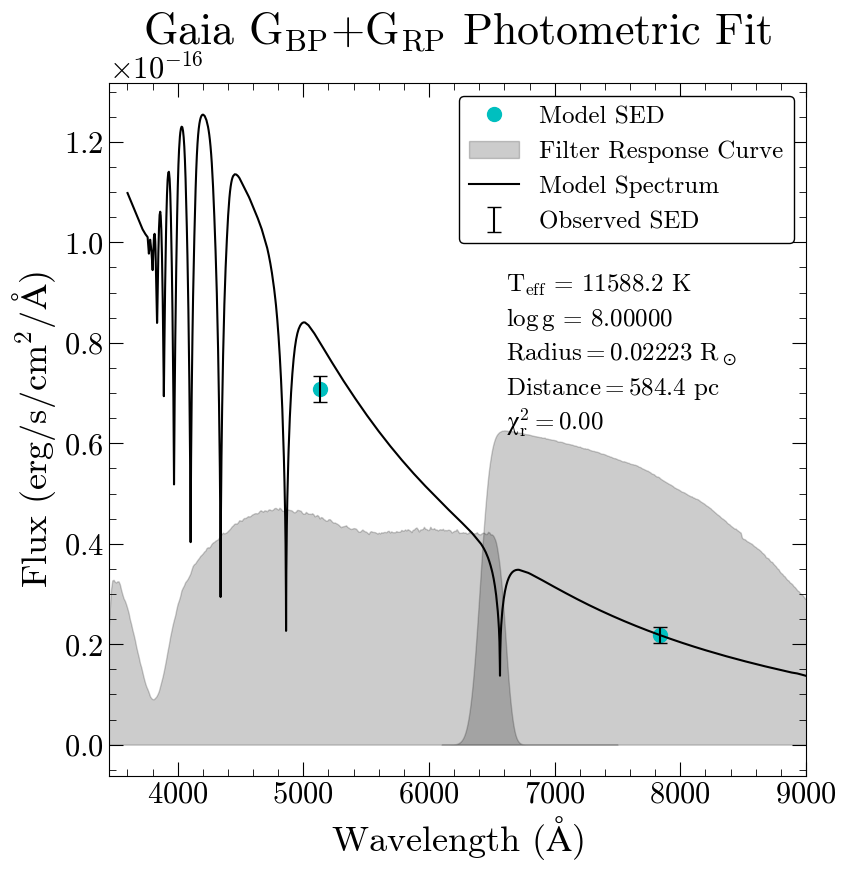

 40%|█████████████████▌                          | 4/10 [00:03<00:05,  1.15it/s]

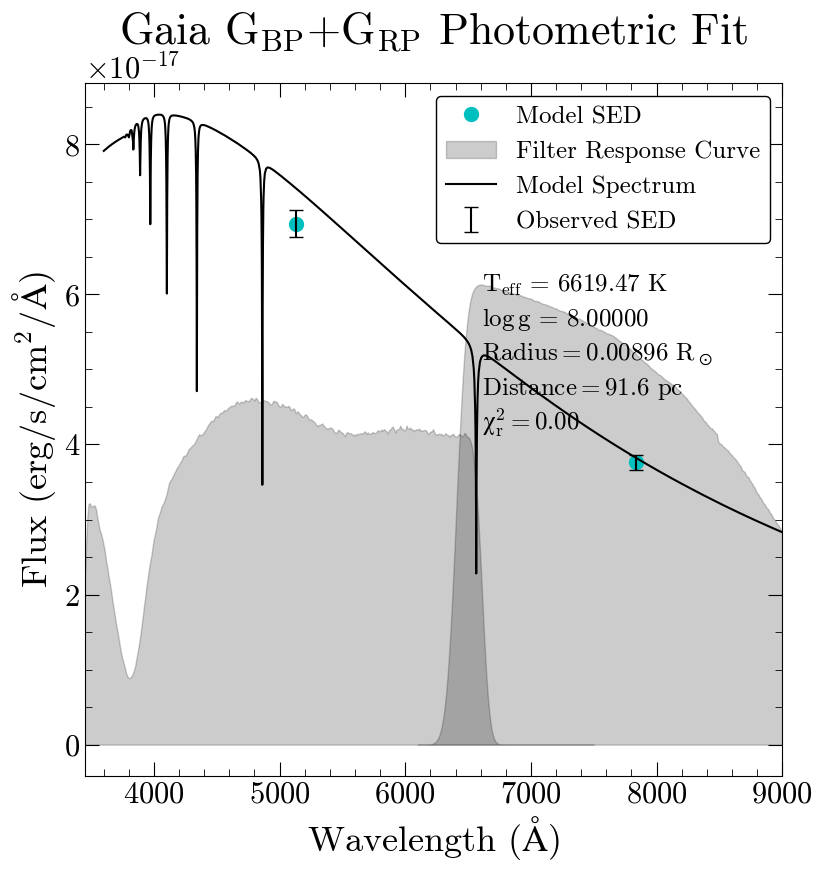

 50%|██████████████████████                      | 5/10 [00:04<00:03,  1.40it/s]

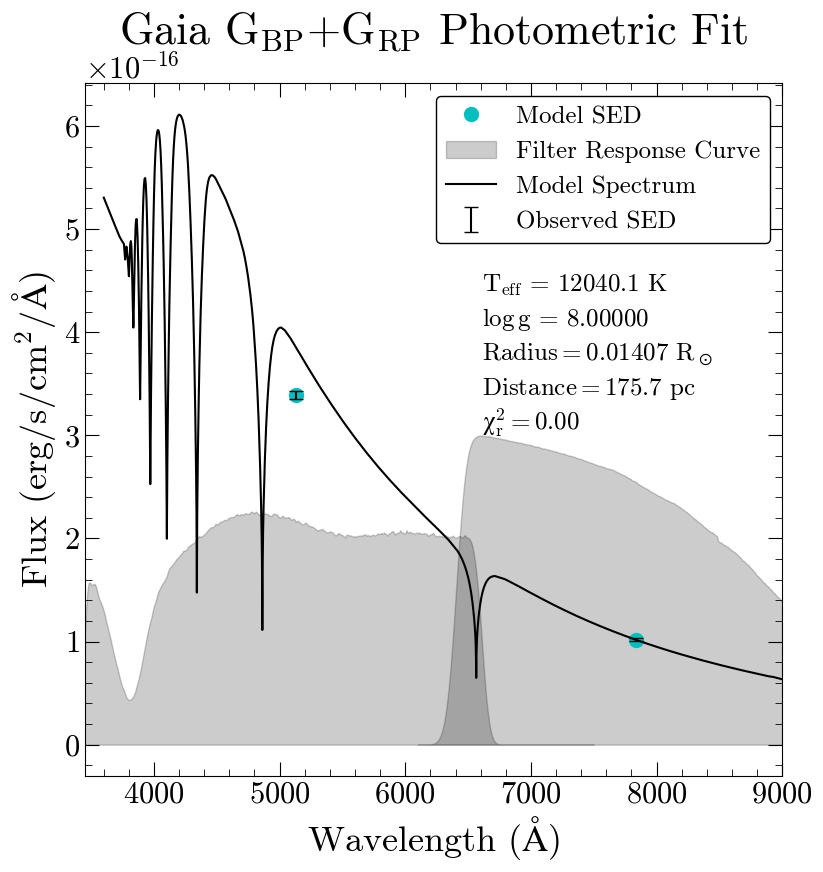

 60%|██████████████████████████▍                 | 6/10 [00:04<00:02,  1.53it/s]

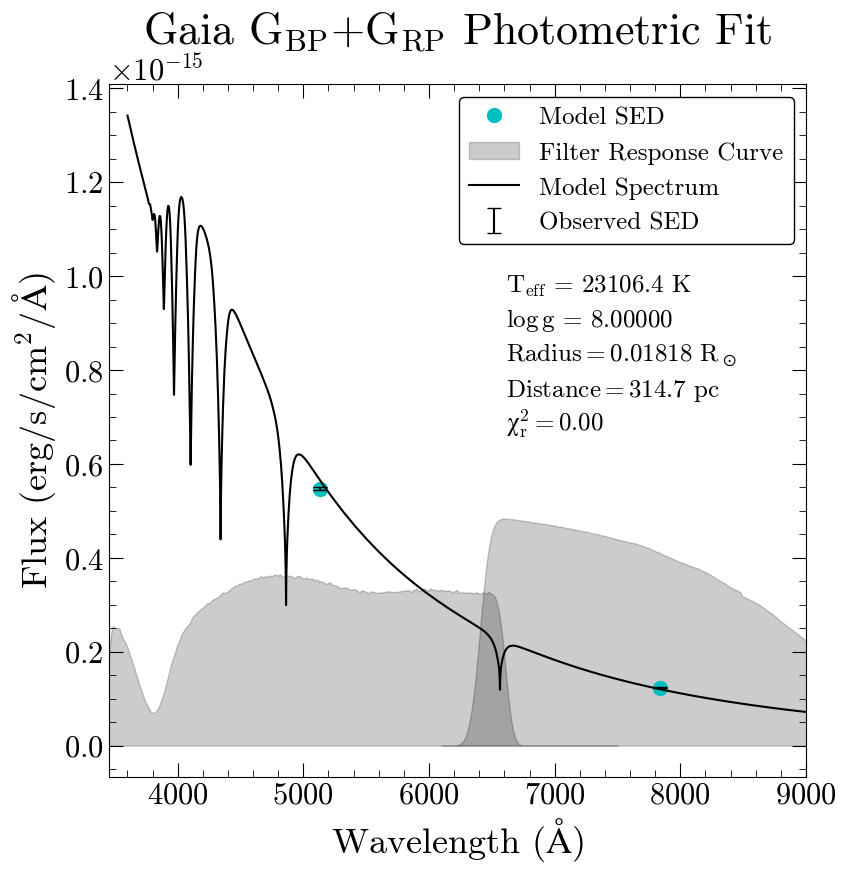

 70%|██████████████████████████████▊             | 7/10 [00:05<00:02,  1.48it/s]

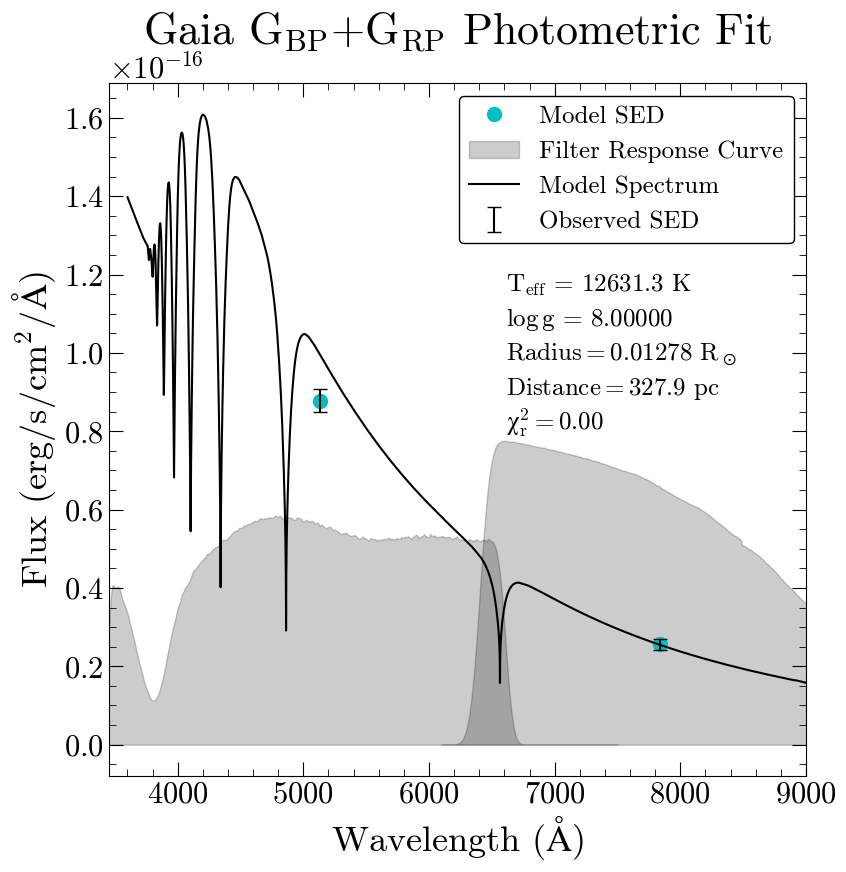

 80%|███████████████████████████████████▏        | 8/10 [00:06<00:01,  1.52it/s]

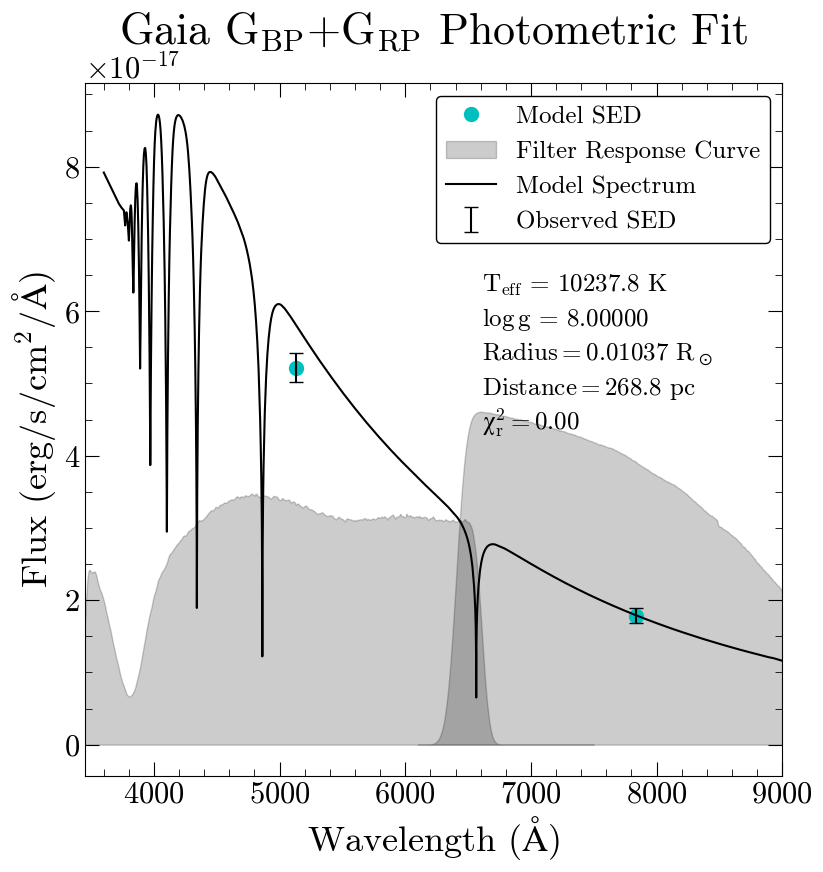

 90%|███████████████████████████████████████▌    | 9/10 [00:06<00:00,  1.54it/s]

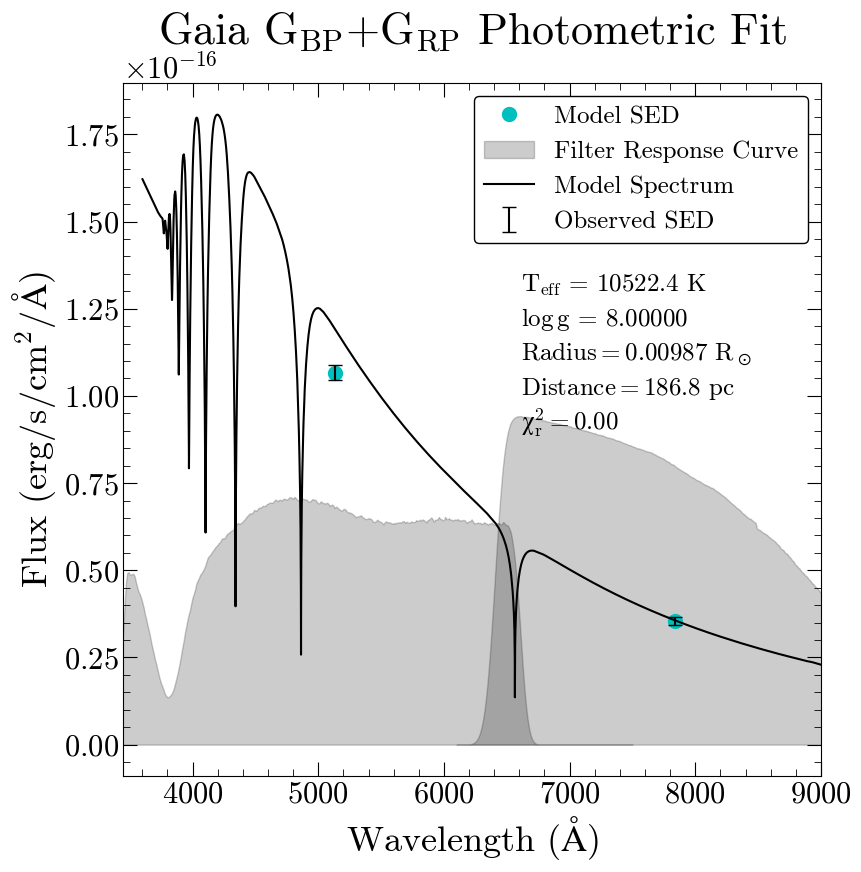

100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.36it/s]


,sdss_id,gaia_dr3_source_id,fieldid,mjd,catalogid21,catalogid25,catalogid31,ra,dec,l,b,r_med_geo,r_lo_geo,r_hi_geo,bailer_jones_flags,n_exp,exptime,snr,classification,p_da,teff_snowwhite,e_teff_snowwhite,logg_snowwhite,e_logg_snowwhite,catalogid,spec_file,pmra,pmra_error,pmdec,pmdec_error,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_mag,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_mag,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,no_distance,no_gaia_phot,clean,prob_psf,psf_mag_u,psf_mag_g,psf_mag_r,psf_mag_i,psf_mag_z,psf_magerr_u,psf_magerr_g,psf_magerr_r,psf_magerr_i,psf_magerr_z,psf_flux_u,psf_flux_g,psf_flux_r,psf_flux_i,psf_flux_z,psf_fluxivar_u,psf_fluxivar_g,psf_fluxivar_r,psf_fluxivar_i,psf_fluxivar_z,mag_ab_u,magerr_ab_u,mag_ab_g,magerr_ab_g,mag_ab_r,magerr_ab_r,mag_ab_i,magerr_ab_i,mag_ab_z,magerr_ab_z,no_sdss_phot,rv_falcon,e_rv_falcon,falcon_flag,logg_raddi,e_logg_raddi,mass_raddi,e_mass_raddi,radius_raddi,rv_raddi,e_rv_raddi,teff_raddi,e_teff_raddi,e_radius_raddi,raddi_flag,teff_anguiano,e_teff_anguiano,mass_anguiano,e_mass_anguiano,logg_anguiano,e_logg_anguiano,snr_anguiano,rv_anguiano,e_rv_anguiano,radius_anguiano,e_radius_anguiano,anguiano_flag,teff_gentile,e_teff_gentile,logg_gentile,e_logg_gentile,mass_gentile,e_mass_gentile,radius_gentile,e_radius_gentile,gentile_flag,teff_koester,e_teff_koester,logg_koester,e_logg_koester,koester_flag,teff_kepler,e_teff_kepler,logg_kepler,e_logg_kepler,rv_kepler,e_rv_kepler,snr_kepler,mass_kepler,e_mass_kepler,radius_kepler,e_radius_kepler,kepler_flag,snowwhite_flag,rv_corv_ind,e_rv_corv_ind,teff_corv_ind,logg_corv_ind,rv_corv_coadd,e_rv_corv_coadd,teff_corv_coadd,logg_corv_coadd,snr_coadd,nspec_coadd,e_rv_corv_ind_full,e_rv_corv_coadd_full,rv_corv_mean,e_rv_corv_mean,nspec_mean_rv_corv,teff_prf_ind,e_teff_prf_ind,logg_prf_ind,e_logg_prf_ind,teff_prf_coadd,e_teff_prf_coadd,logg_prf_coadd,e_logg_prf_coadd,e_teff_prf_ind_full,e_logg_prf_ind_full,e_teff_prf_coadd_full,e_logg_prf_coadd_full,teff_prf_mean,e_teff_prf_mean,logg_prf_mean,e_logg_prf_mean,nspec_mean_teff,nspec_mean_logg,sdssid,av_lo,u_ext_lo,g_ext_lo,r_ext_lo,i_ext_lo,z_ext_lo,gaia_g_ext_lo,gaia_bp_ext_lo,gaia_rp_ext_lo,u_dered_lo,g_dered_lo,r_dered_lo,i_dered_lo,z_dered_lo,gaia_g_dered_lo,gaia_bp_dered_lo,gaia_rp_dered_lo,av_med,u_ext_med,g_ext_med,r_ext_med,i_ext_med,z_ext_med,gaia_g_ext_med,gaia_bp_ext_med,gaia_rp_ext_med,u_dered_med,g_dered_med,r_dered_med,i_dered_med,z_dered_med,gaia_g_dered_med,gaia_bp_dered_med,gaia_rp_dered_med,av_hi,u_ext_hi,g_ext_hi,r_ext_hi,i_ext_hi,z_ext_hi,gaia_g_ext_hi,gaia_bp_ext_hi,gaia_rp_ext_hi,u_dered_hi,g_dered_hi,r_dered_hi,i_dered_hi,z_dered_hi,gaia_g_dered_hi,gaia_bp_dered_hi,gaia_rp_dered_hi,phot_used,phot_radius_sdss_lo,e_phot_radius_sdss_lo,phot_teff_sdss_lo,e_phot_teff_sdss_lo,phot_redchi_sdss_lo,phot_radius_gaia_lo,e_phot_radius_gaia_lo,phot_teff_gaia_lo,e_phot_teff_gaia_lo,phot_redchi_gaia_lo,phot_radius_sdss_med,e_phot_radius_sdss_med,phot_teff_sdss_med,e_phot_teff_sdss_med,phot_redchi_sdss_med,phot_radius_gaia_med,e_phot_radius_gaia_med,phot_teff_gaia_med,e_phot_teff_gaia_med,phot_redchi_gaia_med,phot_radius_sdss_hi,e_phot_radius_sdss_hi,phot_teff_sdss_hi,e_phot_teff_sdss_hi,phot_redchi_sdss_hi,phot_radius_gaia_hi,e_phot_radius_gaia_hi,phot_teff_gaia_hi,e_phot_teff_gaia_hi,phot_redchi_gaia_hi,radius_phot,e_radius_phot,teff_phot,e_teff_phot,phot_logg_sdss_lo,e_phot_logg_sdss_lo,sdss_logg_flag_lo,gaia_logg_flag_lo,phot_logg_sdss_med,e_phot_logg_sdss_med,sdss_logg_flag_med,gaia_logg_flag_med,phot_logg_sdss_hi,e_phot_logg_sdss_hi,sdss_logg_flag_hi,gaia_logg_flag_hi,phot_err_sdss,phot_err_gaia,radius_phot_sdss,e_radius_phot_sdss,radius_phot_gaia,e_radius_phot_gaia,teff_phot_sdss,e_teff_phot_sdss,teff_phot_gaia,e_teff_phot_gaia,e_radius_phot_full,e_teff_phot_full,eta,ruwe,binary_flag,mass_rad_logg,e_mass_rad_logg,mass_logg_theory,e_mass_logg_theory,mass_rad_theory,e_mass_rad_theory,rv_corv_lsr,speed_lsr,thin_disk_flag,rv_

In [11]:
i=0
distance_set='med'
test_table=dict_unique['set_'+str(i)][:10]
    
photometry_source_flag,radius_array_sdss,e_radius_array_sdss,teff_array_sdss,e_teff_array_sdss,logg_array_sdss,e_logg_array_sdss,redchi_array_sdss,radius_array_gaia,e_radius_array_gaia,teff_array_gaia,e_teff_array_gaia,redchi_array_gaia,sdss_logg_flag,gaia_logg_flag=fit_phot(test_table,distance_set,plot=True)

# Save the photometric fit results
test_table['phot_radius_sdss_noext_'+distance_set]=radius_array_sdss
test_table['e_phot_radius_sdss_noext_'+distance_set]=e_radius_array_sdss
test_table['phot_teff_sdss_noext_'+distance_set]=teff_array_sdss
test_table['e_phot_teff_sdss_noext_'+distance_set]=e_teff_array_sdss
test_table['phot_logg_sdss_noext_'+distance_set]=logg_array_sdss
test_table['e_phot_logg_sdss_noext_'+distance_set]=e_logg_array_sdss
test_table['phot_redchi_sdss_noext_'+distance_set]=redchi_array_sdss
test_table['phot_radius_gaia_noext_'+distance_set]=radius_array_gaia
test_table['e_phot_radius_gaia_noext_'+distance_set]=e_radius_array_gaia
test_table['phot_teff_gaia_noext_'+distance_set]=teff_array_gaia
test_table['e_phot_teff_gaia_noext_'+distance_set]=e_teff_array_gaia
test_table['phot_redchi_gaia_noext_'+distance_set]=redchi_array_gaia
test_table['sdss_logg_flag_noext_'+distance_set]=sdss_logg_flag
test_table['gaia_logg_flag_noext_'+distance_set]=gaia_logg_flag

display(test_table)


### Fit all photometric parameters

In [12]:
def parallelprocess_fit_phot(i):
    
    print(i)
    
    distance_sets=['lo','med','hi']
    
    for distance_set in distance_sets:
        photometry_source_flag,radius_array_sdss,e_radius_array_sdss,teff_array_sdss,e_teff_array_sdss,logg_array_sdss,e_logg_array_sdss,redchi_array_sdss,radius_array_gaia,e_radius_array_gaia,teff_array_gaia,e_teff_array_gaia,redchi_array_gaia,sdss_logg_flag,gaia_logg_flag=fit_phot(dict_unique['set_'+str(i)],distance_set,plot=False)

        # Save the photometric fit results
        dict_unique['set_'+str(i)]['phot_radius_sdss_noext_'+distance_set]=radius_array_sdss
        dict_unique['set_'+str(i)]['e_phot_radius_sdss_noext_'+distance_set]=e_radius_array_sdss
        dict_unique['set_'+str(i)]['phot_teff_sdss_noext_'+distance_set]=teff_array_sdss
        dict_unique['set_'+str(i)]['e_phot_teff_sdss_noext_'+distance_set]=e_teff_array_sdss
        dict_unique['set_'+str(i)]['phot_logg_sdss_noext_'+distance_set]=logg_array_sdss
        dict_unique['set_'+str(i)]['e_phot_logg_sdss_noext_'+distance_set]=e_logg_array_sdss
        dict_unique['set_'+str(i)]['phot_redchi_sdss_noext_'+distance_set]=redchi_array_sdss
        dict_unique['set_'+str(i)]['phot_radius_gaia_noext_'+distance_set]=radius_array_gaia
        dict_unique['set_'+str(i)]['e_phot_radius_gaia_noext_'+distance_set]=e_radius_array_gaia
        dict_unique['set_'+str(i)]['phot_teff_gaia_noext_'+distance_set]=teff_array_gaia
        dict_unique['set_'+str(i)]['e_phot_teff_gaia_noext_'+distance_set]=e_teff_array_gaia
        dict_unique['set_'+str(i)]['phot_redchi_gaia_noext_'+distance_set]=redchi_array_gaia
        dict_unique['set_'+str(i)]['sdss_logg_flag_noext_'+distance_set]=sdss_logg_flag
        dict_unique['set_'+str(i)]['gaia_logg_flag_noext_'+distance_set]=gaia_logg_flag
        
        #save as a .csv
        dict_unique['set_'+str(i)].to_csv('csv/unique_phot_short_sets/set_'+str(i)+'.csv',index=False)
        

In [13]:
#run for each set of ids
print(num_id_sets)
#set n_jobs=-2 to spawn n-1 CPU threads where n=total number CPUs available
result=Parallel(n_jobs=-2, verbose=11)(delayed(parallelprocess_fit_phot)(i) for i in range(num_id_sets))


26


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


0
4
3
6
1
2
5


  0%|          | 0/400 [00:00<?, ?it/s]

7


  4%|▍         | 16/400 [00:21<10:12,  1.59s/it]

8


100%|██████████| 400/400 [07:08<00:00,  1.07s/it]
[Parallel(n_jobs=-2)]: Done   3 tasks      | elapsed: 21.1min
  0%|          | 0/400 [00:00<?, ?it/s]

9


100%|██████████| 400/400 [08:21<00:00,  1.25s/it]
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed: 23.8min
  0%|          | 0/400 [00:00<?, ?it/s] 1.05s/it]

10


  0%|          | 0/400 [00:00<?, ?it/s] 1.04s/it]

11


100%|██████████| 400/400 [10:18<00:00,  1.55s/it]
[Parallel(n_jobs=-2)]: Done   6 tasks      | elapsed: 27.9min
  0%|          | 0/400 [00:00<?, ?it/s] 2.05it/s]

12


100%|██████████| 400/400 [09:26<00:00,  1.42s/it]
[Parallel(n_jobs=-2)]: Done   7 tasks      | elapsed: 28.1min
 20%|██        | 81/400 [02:15<06:06,  1.15s/it]

13


100%|██████████| 400/400 [06:37<00:00,  1.01it/s]
[Parallel(n_jobs=-2)]: Done   8 tasks      | elapsed: 39.7min
  8%|▊         | 31/400 [00:45<08:37,  1.40s/it]]

14


100%|██████████| 400/400 [07:40<00:00,  1.15s/it]
[Parallel(n_jobs=-2)]: Done   9 tasks      | elapsed: 45.2min
 78%|███████▊  | 311/400 [08:25<01:38,  1.11s/it]

15


100%|██████████| 400/400 [09:16<00:00,  1.39s/it]
[Parallel(n_jobs=-2)]: Done  10 tasks      | elapsed: 50.2min


16


  0%|          | 0/400 [00:00<?, ?it/s]

17


 36%|███▋      | 145/400 [02:49<03:48,  1.12it/s]

18


100%|██████████| 400/400 [09:25<00:00,  1.41s/it]
[Parallel(n_jobs=-2)]: Done  13 tasks      | elapsed: 58.6min
  0%|          | 0/400 [00:00<?, ?it/s]

19


 78%|███████▊  | 312/400 [07:22<01:25,  1.03it/s]

20


 63%|██████▎   | 252/400 [04:44<01:41,  1.46it/s]

21


 63%|██████▎   | 251/400 [04:36<01:48,  1.38it/s]

22


  0%|          | 0/400 [00:00<?, ?it/s] 4.37s/it]

23


  0%|          | 0/400 [00:00<?, ?it/s] 1.00it/s]

24


100%|██████████| 400/400 [07:30<00:00,  1.13s/it]
[Parallel(n_jobs=-2)]: Done  19 out of  26 | elapsed: 81.3min remaining: 29.9min
  0%|          | 0/207 [00:00<?, ?it/s]

25


100%|██████████| 400/400 [07:36<00:00,  1.14s/it]
[Parallel(n_jobs=-2)]: Done  22 out of  26 | elapsed: 93.8min remaining: 17.0min
100%|██████████| 400/400 [20:26<00:00,  3.07s/it]  
[Parallel(n_jobs=-2)]: Done  26 out of  26 | elapsed: 116.0min finished


### Read back in the short tables
The above method saves the .csv but doesn't overwrite the dataframe, so you have to read back in the results

In [14]:
#read in all data tables
dict_unique={}
for i in tqdm(range(num_id_sets)):
    dict_unique['set_'+str(i)]=pd.read_csv('csv/unique_phot_short_sets/set_'+str(i)+'.csv')

100%|███████████████████████████████████████████| 26/26 [00:00<00:00, 78.61it/s]


### Take the Radius and Teff values measured for the median distance for SDSS photometry if available (Gaia if not) as the final measured value. Add the difference in Radius/Teff measured at the lo and hi distances in quadrature to the measured error

In [15]:
def distance_diff_err(tab_unique):
    #take the med distance of SDSS result (if available) as the phot_radius and phot_teff
    #add the difference between the hi and lo distance radii/teffs in quadrature to the error
    radius_array=[]
    e_radius_array=[]
    for i in range(len(tab_unique)):
        if tab_unique['phot_used'][i]==1:
            radius_array.append(tab_unique['phot_radius_sdss_noext_med'][i])
            try:
                err=np.sqrt(tab_unique['e_phot_radius_sdss_noext_med'][i]**2 + np.abs(tab_unique['phot_radius_sdss_noext_lo'][i] - tab_unique['phot_radius_sdss_noext_hi'][i])**2 )
                e_radius_array.append(err)
            except:
                e_radius_array.append(np.nan)
        elif tab_unique['phot_used'][i]==2:
            radius_array.append(tab_unique['phot_radius_gaia_noext_med'][i])
            try:
                err=np.sqrt(tab_unique['e_phot_radius_gaia_noext_med'][i]**2 + np.abs(tab_unique['phot_radius_gaia_noext_lo'][i] - tab_unique['phot_radius_gaia_noext_hi'][i])**2 )
                e_radius_array.append(err)
            except:
                e_radius_array.append(np.nan)
        else:
            radius_array.append(np.nan)
            e_radius_array.append(np.nan)
    tab_unique['radius_phot_noext']=radius_array
    tab_unique['e_radius_phot_noext']=e_radius_array
    
    #also get a separate final gaia/sdss radius accounting for the distance uncertainties
    radius_array=[]
    e_radius_array=[]
    for i in range(len(tab_unique)):
        radius_array.append(tab_unique['phot_radius_sdss_noext_med'][i])
        try:
            err=np.sqrt(tab_unique['e_phot_radius_sdss_noext_med'][i]**2 + np.abs(tab_unique['phot_radius_sdss_noext_lo'][i] - tab_unique['phot_radius_sdss_noext_hi'][i])**2 )
            e_radius_array.append(err)
        except:
            e_radius_array.append(np.nan)
    tab_unique['radius_phot_sdss_noext']=radius_array
    tab_unique['e_radius_phot_sdss_noext']=e_radius_array
    radius_array=[]
    e_radius_array=[]
    for i in range(len(tab_unique)):
        radius_array.append(tab_unique['phot_radius_gaia_noext_med'][i])
        try:
            err=np.sqrt(tab_unique['e_phot_radius_gaia_noext_med'][i]**2 + np.abs(tab_unique['phot_radius_gaia_noext_lo'][i] - tab_unique['phot_radius_gaia_noext_hi'][i])**2 )
            e_radius_array.append(err)
        except:
            e_radius_array.append(np.nan)
    tab_unique['radius_phot_gaia_noext']=radius_array
    tab_unique['e_radius_phot_gaia_noext']=e_radius_array
    
    #repeat for teff
    teff_array=[]
    e_teff_array=[]
    for i in range(len(tab_unique)):
        if tab_unique['phot_used'][i]==1:
            teff_array.append(tab_unique['phot_teff_sdss_noext_med'][i])
            try:
                err=np.sqrt(tab_unique['e_phot_teff_sdss_noext_med'][i]**2 + np.abs(tab_unique['phot_teff_sdss_noext_lo'][i] - tab_unique['phot_teff_sdss_noext_hi'][i])**2 )
                e_teff_array.append(err)
            except:
                e_teff_array.append(np.nan)
        elif tab_unique['phot_used'][i]==2:
            teff_array.append(tab_unique['phot_teff_gaia_noext_med'][i])
            try:
                err=np.sqrt(tab_unique['e_phot_teff_gaia_noext_med'][i]**2 + np.abs(tab_unique['phot_teff_gaia_noext_lo'][i] - tab_unique['phot_teff_gaia_noext_hi'][i])**2 )
                e_teff_array.append(err)
            except:
                e_teff_array.append(np.nan)
        else:
            teff_array.append(np.nan)
            e_teff_array.append(np.nan)
    tab_unique['teff_phot_noext']=teff_array
    tab_unique['e_teff_phot_noext']=e_teff_array
    
    teff_array=[]
    e_teff_array=[]
    for i in range(len(tab_unique)):
        teff_array.append(tab_unique['phot_teff_sdss_noext_med'][i])
        try:
            err=np.sqrt(tab_unique['e_phot_teff_sdss_noext_med'][i]**2 + np.abs(tab_unique['phot_teff_sdss_noext_lo'][i] - tab_unique['phot_teff_sdss_noext_hi'][i])**2 )
            e_teff_array.append(err)
        except:
            e_teff_array.append(np.nan)
    tab_unique['teff_phot_sdss_noext']=teff_array
    tab_unique['e_teff_phot_sdss_noext']=e_teff_array
    teff_array=[]
    e_teff_array=[]
    for i in range(len(tab_unique)):
        teff_array.append(tab_unique['phot_teff_gaia_noext_med'][i])
        try:
            err=np.sqrt(tab_unique['e_phot_teff_gaia_noext_med'][i]**2 + np.abs(tab_unique['phot_teff_gaia_noext_lo'][i] - tab_unique['phot_teff_gaia_noext_hi'][i])**2 )
            e_teff_array.append(err)
        except:
            e_teff_array.append(np.nan)
    tab_unique['teff_phot_gaia_noext']=teff_array
    tab_unique['e_teff_phot_gaia_noext']=e_teff_array
    
    return(tab_unique)

In [16]:
for i in tqdm(range(num_id_sets)):
    dict_unique['set_'+str(i)]=distance_diff_err(dict_unique['set_'+str(i)])
    #save as a .csv
    dict_unique['set_'+str(i)].to_csv('csv/unique_phot_short_sets/set_'+str(i)+'.csv',index=False)
    

100%|███████████████████████████████████████████| 26/26 [00:02<00:00, 10.82it/s]


### Combine all the dataframes together


In [17]:
#combine all the dataframes together
tab_unique=pd.concat([dict_unique['set_0'], dict_unique['set_1']], ignore_index=True)
for i in tqdm(range(num_id_sets-2)):
    tab_unique=pd.concat([tab_unique, dict_unique['set_'+str(i+2)]], ignore_index=True)
#reset the indices
indices=np.arange(0,len(tab_unique))
tab_unique.set_index(indices,inplace=True)

#save as a .csv
tab_unique.to_csv('csv/unique_phot_short_sets/tab_unique.csv',index=False)
    

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 337.32it/s]


In [18]:
#read back in
tab_unique=pd.read_csv('csv/unique_phot_short_sets/tab_unique.csv')

/var/folders/ny/bjybyvhj6s9_2ms5cmld1xbc0000gn/T/ipykernel_91893/280458397.py:2: DtypeWarning: Columns (18,25,77,88,100,109,114,126,127,292) have mixed types. Specify dtype option on import or set low_memory=False.
  tab_unique=pd.read_csv('csv/unique_phot_short_sets/tab_unique.csv')


In [19]:
#add the masses to the dataframe
MsunCGS=1.989*10**33 #g
RsunCGS=6.955*10**10 #cm
cCGS=2.99792458*10**10 #cm/s
GCGS=6.6743*10**(-8) #cm^3 g^-1 s^-2

def data_m_from_r_logg(radii,loggs,e_radii,e_loggs):
    #compute the mass and error on the mass in solar units
    #given measured radius and logg
    masses=[]
    e_masses=[]
    #convert radii from solar units to CGS units
    radii=radii*RsunCGS
    e_radii=e_radii*RsunCGS
    #get the surface gravity
    gs=10**(loggs)
    for i in range(len(radii)):
        M=(gs[i]*(radii[i]**2)/GCGS)/MsunCGS
        masses.append(M)
        E_M=((gs[i]*radii[i]/GCGS)*np.sqrt(4*(e_radii[i]**2)+((radii[i]*np.log(10))**2)*(e_loggs[i]**2)))/MsunCGS
        e_masses.append(E_M)
    return(masses,e_masses)

def add_mass(table):
    #compute the mass in solar units using coadded spectral parameters
    
    #from measured logg and measured radius
    mass_rad_logg, e_mass_rad_logg=data_m_from_r_logg(table['radius_phot_noext'],table['logg_prf_coadd'],table['e_radius_phot_full'],
                                table['e_logg_prf_coadd_full'])
    
    #don't add the error on the mass since we would have to re-do the systematic error analysis to get updated full errors
    table['mass_rad_logg_noext']=mass_rad_logg
    
    return(table)

In [20]:
tab_unique=add_mass(tab_unique)

In [21]:
#save as a .csv
tab_unique.to_csv('csv/unique_phot_short_sets/tab_unique.csv',index=False)

In [22]:
#save as a .csv
tab_unique.to_csv('csv/wd_table_noext.csv',index=False)

In [23]:
#read back in if needed
tab_unique=pd.read_csv('csv/wd_table_noext.csv')

/var/folders/ny/bjybyvhj6s9_2ms5cmld1xbc0000gn/T/ipykernel_91893/1015045696.py:2: DtypeWarning: Columns (18,25,77,88,100,109,114,126,127,292) have mixed types. Specify dtype option on import or set low_memory=False.
  tab_unique=pd.read_csv('csv/wd_table_noext.csv')


# Compare photometric radii/teffs measured with no extinction to those measured with extinction as a function of Av
- Also plotted as function of distance and radius/teff, Av is best indicator of difference

### Bin the samples in Av and compute the average difference between the extinction-corrected and uncorrected radius and teff

In [24]:
av_bins=np.append(np.arange(0,0.65,0.05),2)
av_bins=np.round(av_bins,2)
print(av_bins)

#get the range and center for each bin
av_bin_ranges=[]
av_bin_centers=[]
for i in range(len(av_bins)-1):
    array=[av_bins[i],av_bins[i+1]]
    half=0.5*(av_bins[i]+av_bins[i+1])
    av_bin_ranges.append(array)
    av_bin_centers.append(half)
av_bin_nums=np.arange(0,len(av_bin_ranges))

#save the bin info
np.savez('csv/av_bins',bins=av_bins,ranges=av_bin_ranges,centers=av_bin_centers,nums=av_bin_nums)

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  2.  ]


In [25]:
def bin_by_av(table,verbose=False):
    #bin by Av
    av_bin_ids=[]
    av_bin_id_ranges=[]
    av_bin_id_centers=[]
    for i in range(len(table)):
        av_val=table['av_med'][i]
        for j in range(len(av_bin_ranges)):
            if av_bin_ranges[j][0]<=av_val<av_bin_ranges[j][1]:
                av_bin_ids.append(j)
                av_bin_id_ranges.append(av_bin_ranges[j])
                av_bin_id_centers.append(av_bin_centers[j])
    table['av_bin_id']=av_bin_ids
    table['av_bin_range']=av_bin_id_ranges
    table['av_bin_center']=av_bin_id_centers
    
    if verbose==True:
        for i in range(len(av_bin_ranges)):
            bin_num=av_bin_nums[i]
            bin_range=av_bin_ranges[i]
            tmp=table.query('av_bin_id==@bin_num')
            print('Bin id=', bin_num,' Bin range=',bin_range,' mag, Number of WDs in bin=',len(tmp))
            
    return(table)

In [26]:
binning_table=tab_unique[['av_med','radius_phot','radius_phot_noext','teff_phot','teff_phot_noext']]

In [27]:
#bin in Av
binning_table=bin_by_av(binning_table,verbose=True)


Bin id= 0  Bin range= [0.0, 0.05]  mag, Number of WDs in bin= 6185
Bin id= 1  Bin range= [0.05, 0.1]  mag, Number of WDs in bin= 2441
Bin id= 2  Bin range= [0.1, 0.15]  mag, Number of WDs in bin= 696
Bin id= 3  Bin range= [0.15, 0.2]  mag, Number of WDs in bin= 343
Bin id= 4  Bin range= [0.2, 0.25]  mag, Number of WDs in bin= 161
Bin id= 5  Bin range= [0.25, 0.3]  mag, Number of WDs in bin= 122
Bin id= 6  Bin range= [0.3, 0.35]  mag, Number of WDs in bin= 80
Bin id= 7  Bin range= [0.35, 0.4]  mag, Number of WDs in bin= 49
Bin id= 8  Bin range= [0.4, 0.45]  mag, Number of WDs in bin= 30
Bin id= 9  Bin range= [0.45, 0.5]  mag, Number of WDs in bin= 35
Bin id= 10  Bin range= [0.5, 0.55]  mag, Number of WDs in bin= 14
Bin id= 11  Bin range= [0.55, 0.6]  mag, Number of WDs in bin= 12
Bin id= 12  Bin range= [0.6, 2.0]  mag, Number of WDs in bin= 39


In [28]:
def binned_med_std(table,parameter):
                    
    #calculate the mean/std x for each bin
    bin_nums=av_bin_nums
    bin_ranges=av_bin_ranges
    bin_centers=av_bin_centers
    bin_id_key='av_bin_id'

    med_xs=[]
    std_xs=[]
    num_obs_per_bin=[]
    for i in range(len(bin_nums)):
        tmp=table.query(bin_id_key+'=='+str(bin_nums[i]))
        if parameter=='radius':
            x=tmp['radius_phot']-tmp['radius_phot_noext']
        if parameter=='teff':
            x=tmp['teff_phot']-tmp['teff_phot_noext']
        if len(x)>0:
            #calculate mean and std of x
            med_x=np.nanmedian(x)#nanmean(x)
            std_x=np.nanstd(x)
        else: #if bin is empty fill with nan values
            med_x=np.nan
            std_x=np.nan
        #record results
        med_xs.append(med_x)
        std_xs.append(std_x)
        #record how many observations used in averaging
        num_obs=len(tmp)
        num_obs_per_bin.append(num_obs)

    #convert bin ranges to string
    bin_ranges_str=[]
    for i in range(len(bin_ranges)):
        bin_ranges_str.append(str(bin_ranges[i]))
    
    #save parameters
    final_avg_table=pd.DataFrame()
    final_avg_table['bin_id']=bin_nums
    final_avg_table['bin_range']=bin_ranges_str
    final_avg_table['bin_center']=bin_centers
    
    final_avg_table['med_difference']=med_xs
    final_avg_table['std_difference']=std_xs
    final_avg_table['num_obs_per_bin']=num_obs_per_bin
    
    #re-order by bin_id
    final_avg_table=final_avg_table.sort_values(by=['bin_id'])
    
    return(final_avg_table)

In [29]:
#get the median and std of the difference between the measured values with and without
#correcting for extinction for each radius/teff
radius_extinction=binned_med_std(binning_table,'radius')
teff_extinction=binned_med_std(binning_table,'teff')


In [30]:
#save these tables, to characterize the effects of extinction on measured parameters
#we will draw a difference from a normal distrbution with mean/std from these tables in nb06
radius_extinction.to_csv('csv/extinction_effect_radius.csv',index=False)
teff_extinction.to_csv('csv/extinction_effect_teff.csv',index=False)

#NOTE if Av==0, then difference between the corrected/uncorrected is 0

# Final Plot

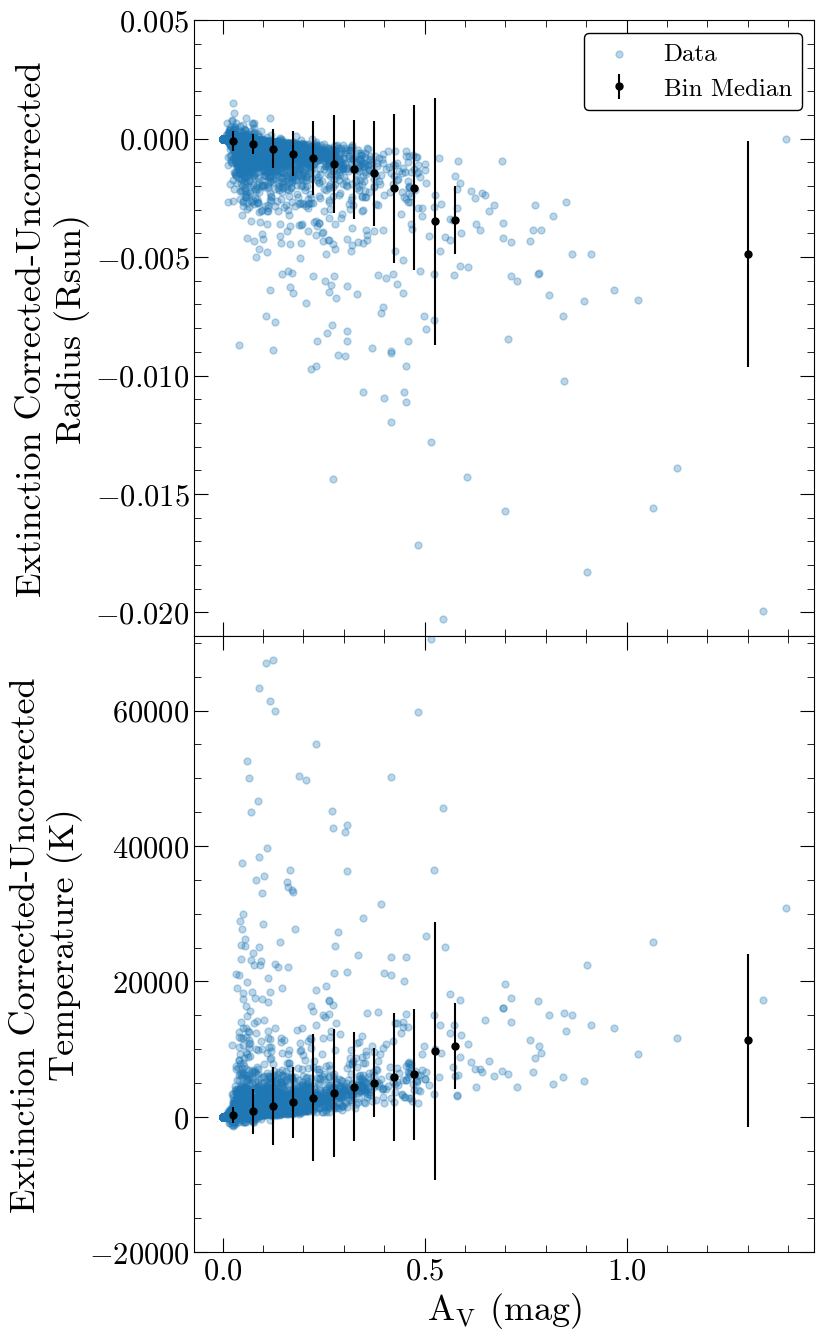

In [31]:
#plot the effect of the dust on measuring the radius/teff
fig, ((ax1),(ax2)) =plt.subplots(2,1,figsize=(8,16),sharex=True)
ax1.scatter(tab_unique['av_med'],tab_unique['radius_phot']-tab_unique['radius_phot_noext'],rasterized=True,alpha=0.3,label='Data')
ax1.errorbar(radius_extinction['bin_center'],radius_extinction['med_difference'], yerr=radius_extinction['std_difference'],
             fmt='o', color='black', ecolor = 'black',label='Bin Median')
ax1.set_ylabel('Extinction Corrected-Uncorrected\nRadius (Rsun)')
ax1.legend()

ax2.scatter(tab_unique['av_med'],tab_unique['teff_phot']-tab_unique['teff_phot_noext'],rasterized=True,alpha=0.3,label='Data')
ax2.errorbar(teff_extinction['bin_center'],teff_extinction['med_difference'], yerr=teff_extinction['std_difference'],
             fmt='o', color='black', ecolor = 'black',label='Bin Median')
ax2.set_xlabel('$A_V$ (mag)')
ax2.set_ylabel('Extinction Corrected-Uncorrected\nTemperature (K)')

ax1.set_ylim(-0.021,0.005)
ax2.set_ylim(-20000,71000)

plt.subplots_adjust(hspace=0)

plt.savefig('dust.pdf', dpi=300)
